<a id="toc"></a>

# <p style="background-color: #008080; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:5px 5px;">Auto Scout Car Prices Prediction Project: <br> Handling Outliers </p>

## <p style="background-color: #008080; font-family:newtimeroman; color:#FFF9ED; font-size:150%; text-align:center; border-radius:10px 10px;">Content</p>

* [INTRODUCTION](#0)
* [IMPORTING LIBRARIES](#1)
* [HANDLING OUTLIERS](#2)
* [FUNCTIONS FOR VISUALIZATION](#fn)
* [THE END OF HANDLING OUTLIERS](#3)

<a id="0"></a>

## Introduction


Welcome to "***Auto Scout Car Price Prediction Project***". 

**Auto Scout** data used for this project, were scraped from the on-line car trading company, Auto Scout, in 2019, contains many features of 9 different car models. In this project, I will go through all the steps of a data project: data cleaning, modeling, features selection, and model selection. 

In the first part of this project I will apply many commonly used algorithms for data cleaning and exploratory data analysis by using many Python libraries such as Numpy, Pandas, Matplotlib, Seaborn, Scipy.

These are the steps for the first part. 
* **[data cleaning](00_data_cleaning.ipynb)** -  dealing with incorrect headers (column names), incorrect format, anomalies, and dropping obviously  useless columns.
* **[data imputation](01_data_imputation.ipynb)** - handling missing values, reducing classes in features to be encoded.
* **[handling outliers](02_data_viz_&_outliers.ipynb)** -  via visualisation libraries. Some insights are extracted.

In the second part of the project I explore many types of models for predicting prices. I explore OLS, Ridge, Lasso, SGD, Random Forest, XGB, light GBM, and catBoost.

* **[data encoding](03_data_encoding.ipynb)** in preparation for modeling: converting multiclass features into dummy columns, making dummy columns from nested features.
* **[modeling](04_modeling.ipynb)** trying out different models, model selection, feature selection, and cross-validation.

<a id="1"></a>

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap()
import seaborn as sns
import numpy as np
import pandas as pd
from random import choices, seed
seed = 42
import regex as re

<a id="fn"></a>

## Functions for Visualization

In [2]:
def plot_box(df, f_x, f_y, f_hue=None):
    plt.figure(figsize = (15, 5))
    category_median = df.groupby(f_x)[f_y].median().sort_values()
    order = category_median.index
    if f_hue == None:
        sns.boxplot(data=df, x=f_y, y=f_x, hue=f_hue, order=order)
    else:
        hue_order = df[f_hue].unique()
        if len(hue_order) > 2:
            hue_order.sort()
        sns.boxplot(data=df, x=f_x, y=f_y, hue=f_hue, order=order, hue_order=hue_order)

In [3]:
def fill(df, f_fill, f_use, how):
    '''
    function takes a dataframe, a feature for which missing values are to be filled, and 
    a list of features to group by, and a method from the list [median, mode].
    
    df = dataframe
    f_fill = name of feature with missing values to impute
    l_f_use = list of features based on which the missing values are to be impute, in order of decreasing importance
    '''
    
    if how == 'mode':
        uniq_f_use = df[f_use].unique()
        for u in uniq_f_use:
            if len(df[df[f_use] == u][f_fill]) > 0:
                v = df[df[f_use] == u][f_fill].mode()
                if len(v) > 0:
                    v = v[0]
                else:
                    v = float('nan')
                    print('empty class')    
            else:
                v = float('nan')
                print('empty class')
            df.loc[df[f_use] == u, f_fill] = \
                    df.loc[df[f_use] == u, f_fill].fillna(v)
        return df
    
    if how == 'median':
        uniq_f_use = df[f_use].unique()
        for u in uniq_f_use:
            if len(df[df[f_use] == u][f_fill]) > 0:
                v = df[df[f_use] == u][f_fill].median()
            else:
                v = float('nan')
                print('empty class')
            df.loc[df[f_use] == u, f_fill] = \
                    df.loc[df[f_use] == u, f_fill].fillna(v)
        return df
    
    if how == 'mean':
        uniq_f_use = df[f_use].unique()
        for u in uniq_f_use:
            if len(df[df[f_use] == u][f_fill]) > 0:
                v = df[df[f_use] == u][f_fill].mean()
            else:
                v = float('nan')
                print('empty class')
            df.loc[df[f_use] == u, f_fill] = \
                    df.loc[df[f_use] == u, f_fill].fillna(v)
        return df

<a id="2"></a>
## Handing Outliers


In [4]:
df = pd.read_json('data_post01.json', lines=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15884 entries, 0 to 15883
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make_model           15884 non-null  object 
 1   body_type            15884 non-null  object 
 2   price                15884 non-null  int64  
 3   km                   15884 non-null  float64
 4   prev_owner           15884 non-null  int64  
 5   hp                   15884 non-null  int64  
 6   type                 15884 non-null  object 
 7   first_registration   15884 non-null  int64  
 8   body_color           15884 non-null  object 
 9   paint_type           15884 non-null  object 
 10  nr_doors             15884 non-null  int64  
 11  nr_seats             15884 non-null  int64  
 12  gearing_type         15884 non-null  object 
 13  displacement         15884 non-null  int64  
 14  cylinders            15884 non-null  int64  
 15  weight               15884 non-null 

## Column by Column Visualization and Dealing with Outlier 

### Target column is price, I will observe that first and then in the order they are in the dataframe

### exploring 'price'

* visualizations to draw useful relationships

<AxesSubplot:ylabel='Frequency'>

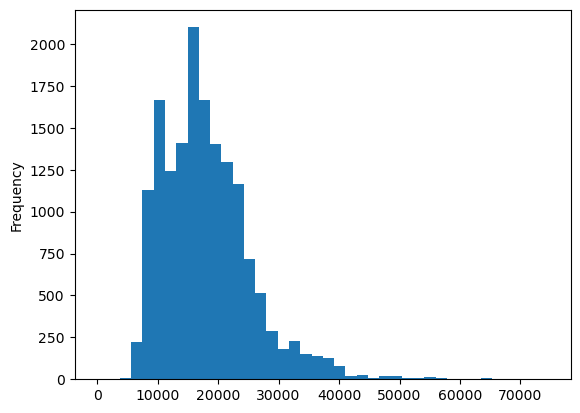

In [6]:
df.price.plot.hist(bins=40)

### make_model

In [7]:
df.make_model.value_counts()

audi_a3           3097
audi_a1           2614
opel_insignia     2598
opel_astra        2526
opel_corsa        2219
renault_clio      1839
renault_espace     991
Name: make_model, dtype: int64

#### price and make_model

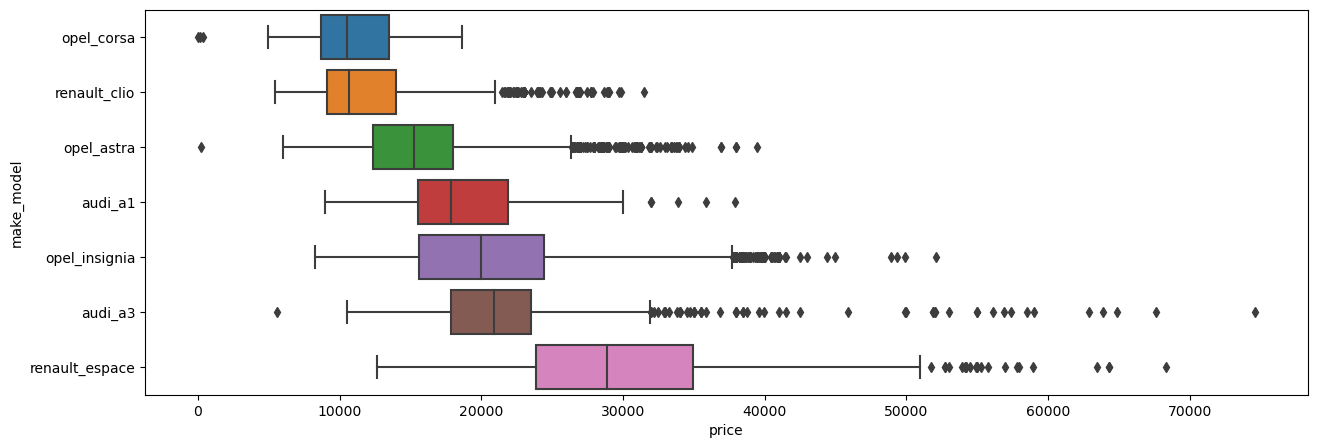

In [8]:
plot_box(df, 'make_model', 'price')

### first_registration

In [9]:
df.first_registration.value_counts()

2018    4521
2019    4416
2016    3674
2017    3273
Name: first_registration, dtype: int64

#### price and first_registration

#### there is monotonicity in median prices by year of registration

Text(0.4, 1, ' Monotonicity in median prices by year of registration')

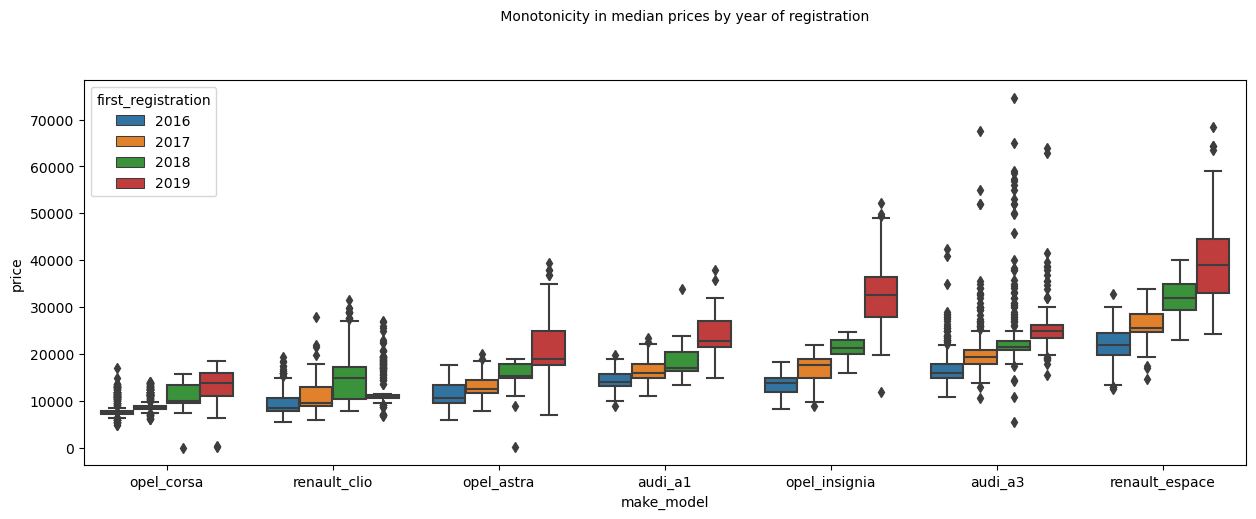

In [10]:
plot_box(df, 'make_model', 'price', 'first_registration')
plt.figtext(0.4,1, " Monotonicity in median prices by year of registration")

### type

In [11]:
df.type.value_counts()

used              11082
new                1632
pre_registered     1364
employees_car      1010
demonstration       796
Name: type, dtype: int64

#### price and type

Text(0.1, 0.95, 'used valued least, demo cars priced most')

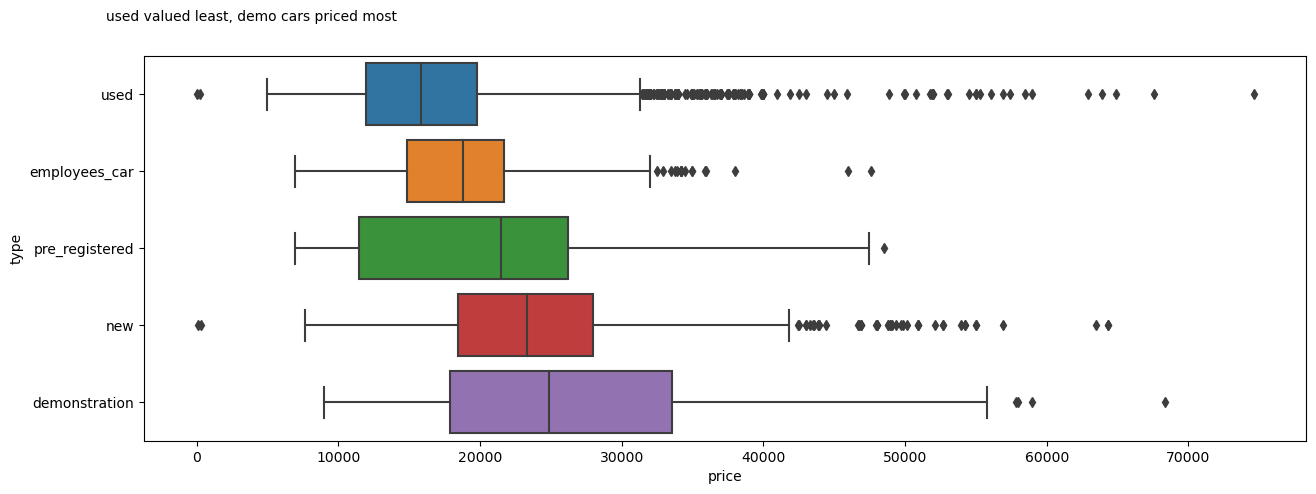

In [12]:
plot_box(df, 'type', 'price')
plt.figtext(0.1,.95, "used valued least, demo cars priced most")

Text(0.1, 0.9, 'New, Demonstration, and Pre-registered cars valued more than Employees and Used')

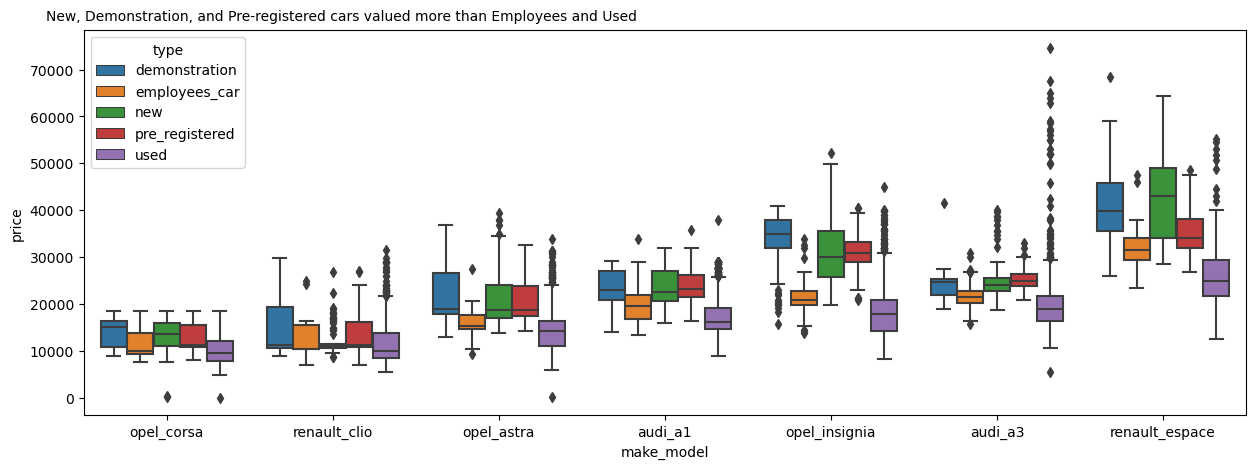

In [13]:
plot_box(df, 'make_model', 'price', 'type')
plt.figtext(0.1,.9, "New, Demonstration, and Pre-registered cars valued more than Employees and Used")

### body_type

In [14]:
df.body_type.value_counts()

sedans           7925
station wagon    3563
compact          3155
van               809
other             432
Name: body_type, dtype: int64

#### price and body_type

Text(0.1, 0.9, 'Vans are more expensive')

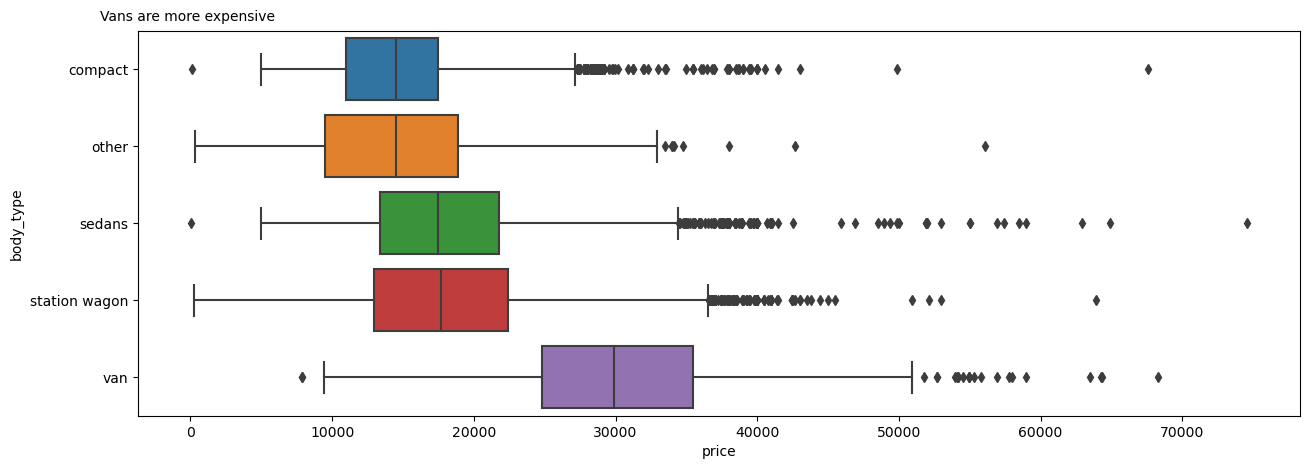

In [15]:
plot_box(df, 'body_type', 'price')
plt.figtext(0.1,.9, "Vans are more expensive")

Text(0.1, 0.9, 'Vans are most expensive, sedans and station wagons alike, compact and others alike')

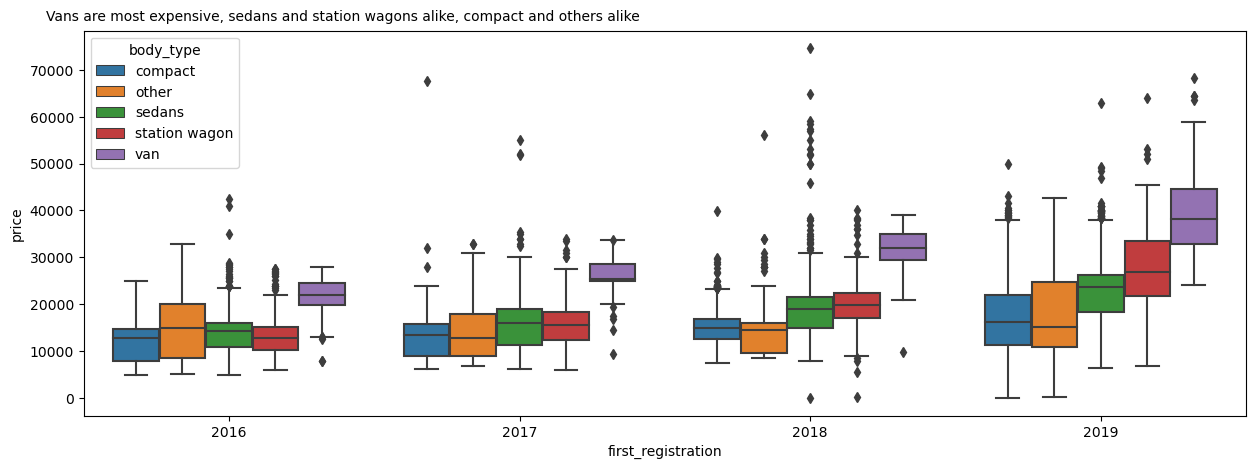

In [16]:
plot_box(df, 'first_registration', 'price', 'body_type')
plt.figtext(0.1,.9, "Vans are most expensive, sedans and station wagons alike, compact and others alike")

### km

<AxesSubplot:xlabel='km', ylabel='Density'>

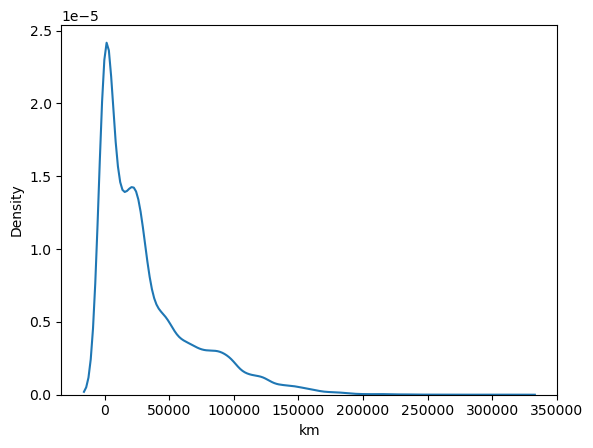

In [17]:
sns.kdeplot(df.km)

km in 1000s

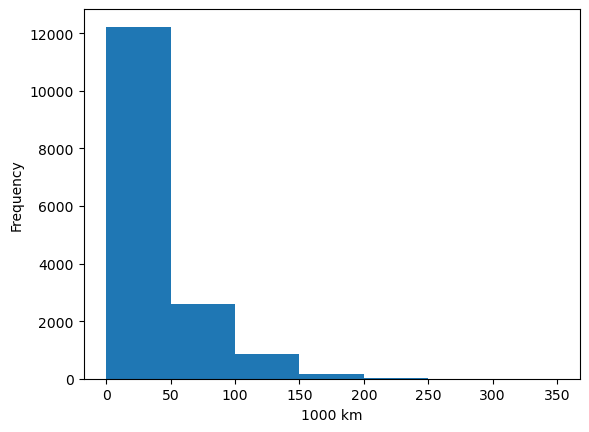

In [18]:
km1000 = df.km//1000
ax = km1000.plot.hist(bins=range(0,int(km1000.max())+50,50))
ax.set_xlabel('1000 km')
plt.show()

In [19]:
df['km_10000'] = df.km//10000
df['km_10000'] = [str(int(x)) for x in df.km_10000]
df['km_10000'].count(), df['km_10000'][df.km<50000].count()

(15884, 12230)

In [20]:
df['km_10000'][df.km<50000].value_counts()

0    5677
2    2442
1    2125
3    1051
4     935
Name: km_10000, dtype: int64

#### price and km

Text(0.1, 0.9, 'median prices are (almost) monotonous with 10,000 km groups')

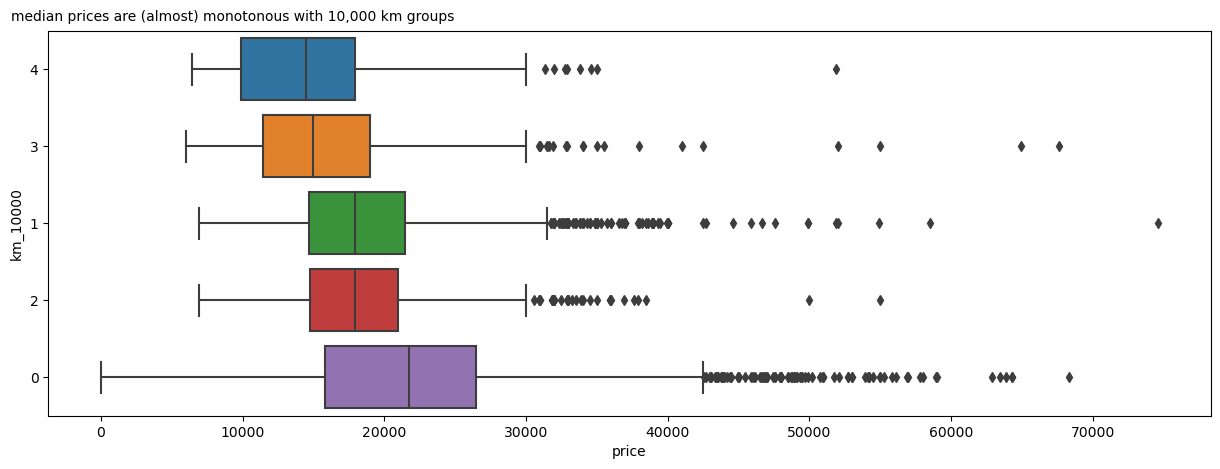

In [21]:
plot_box(df[df.km<50000],'km_10000', 'price')
plt.figtext(0.1,0.9,'median prices are (almost) monotonous with 10,000 km groups')

Text(0.1, 0.9, 'median prices are monotonous with 10,000 km groups')

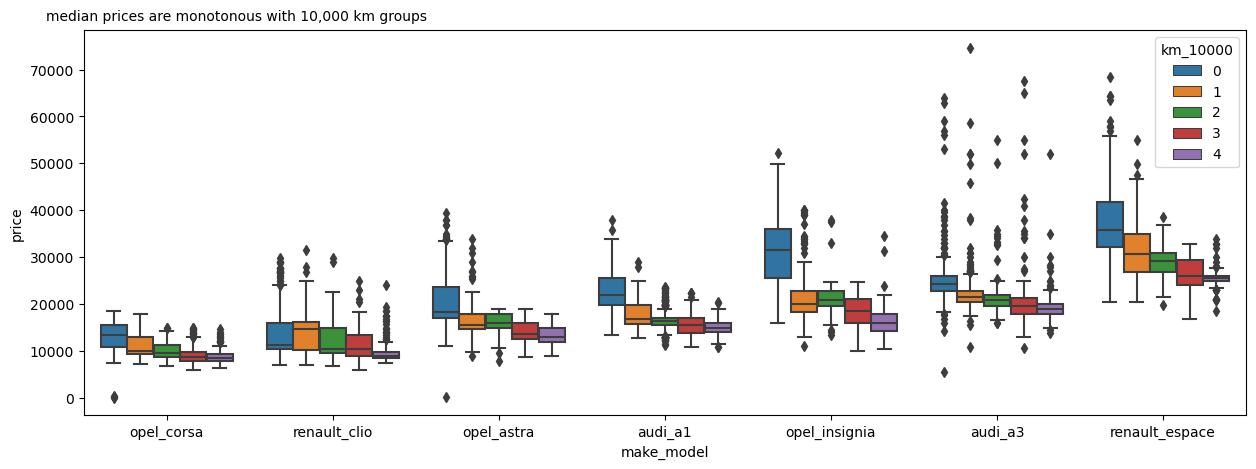

In [22]:
plot_box(df[df.km<50000],'make_model', 'price','km_10000')
plt.figtext(0.1,0.9,'median prices are monotonous with 10,000 km groups')

In [23]:
df = df.drop('km_10000', axis = 1)

### prev_owner

In [24]:
df.prev_owner.value_counts()

1    8293
0    6794
2     778
3      17
4       2
Name: prev_owner, dtype: int64

#### price and prev_owner

Text(0.25, 1, '0 or 1 previous owners - not very different. More previous owners - valued lower')

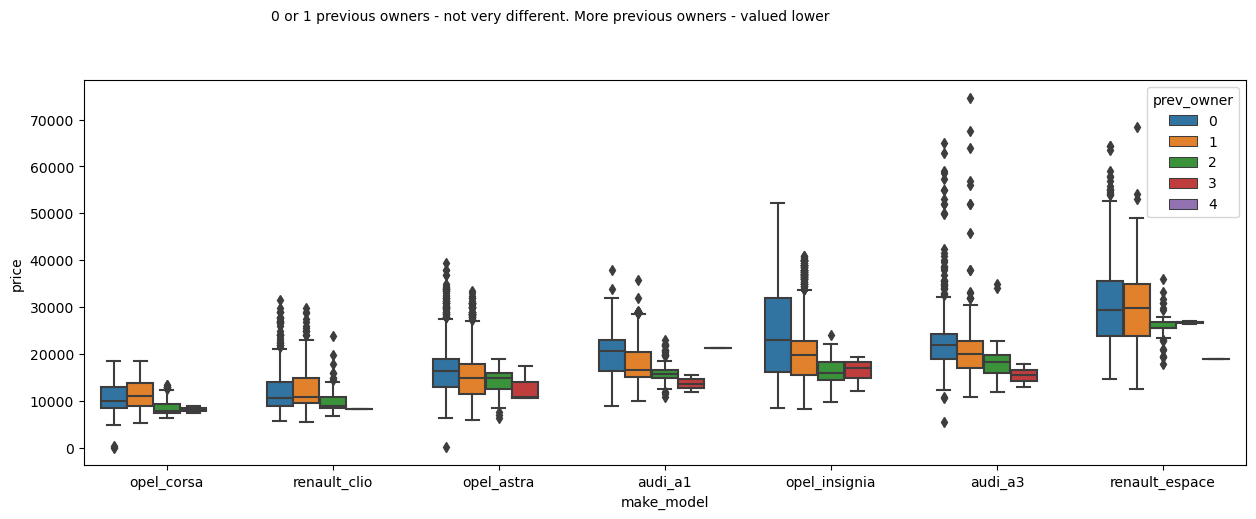

In [25]:
plot_box(df,'make_model', 'price', 'prev_owner')
plt.figtext(0.25,1, "0 or 1 previous owners - not very different. More previous owners - valued lower")

### body_color

In [26]:
df.body_color.value_counts()

black     4334
grey      3504
white     3380
silver    1647
blue      1431
red        957
brown      289
green      154
beige      108
yellow      51
violet      18
bronze       6
orange       3
gold         2
Name: body_color, dtype: int64

#### price and body_color (ignoring violet, bronze, orange, gold)

In [27]:
vc = df.body_color.value_counts()
print(vc)
keep = [i for i in vc.index]
print(keep)

black     4334
grey      3504
white     3380
silver    1647
blue      1431
red        957
brown      289
green      154
beige      108
yellow      51
violet      18
bronze       6
orange       3
gold         2
Name: body_color, dtype: int64
['black', 'grey', 'white', 'silver', 'blue', 'red', 'brown', 'green', 'beige', 'yellow', 'violet', 'bronze', 'orange', 'gold']


In [28]:
df_temp = df[[x in ['black', 'grey', 'white', 'silver', 'blue', 'red'] for x in df.body_color]]

Text(0.1, 0.95, 'Priece not very different for these colors')

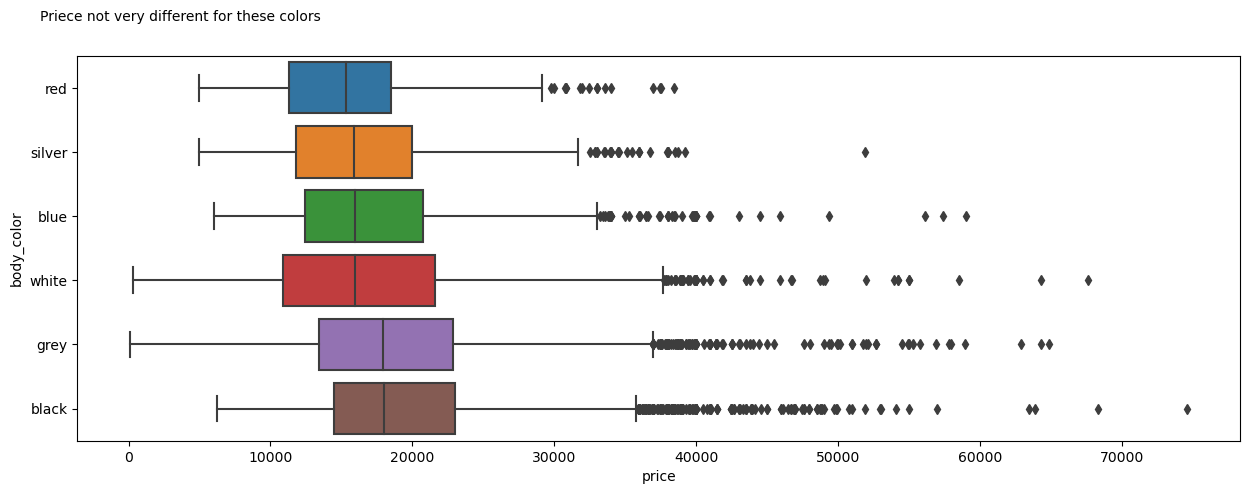

In [29]:
plot_box(df_temp, 'body_color', 'price')
plt.figtext(0.1,.95, "Priece not very different for these colors")

Text(0.1, 0.95, 'Prices not very different for these colors')

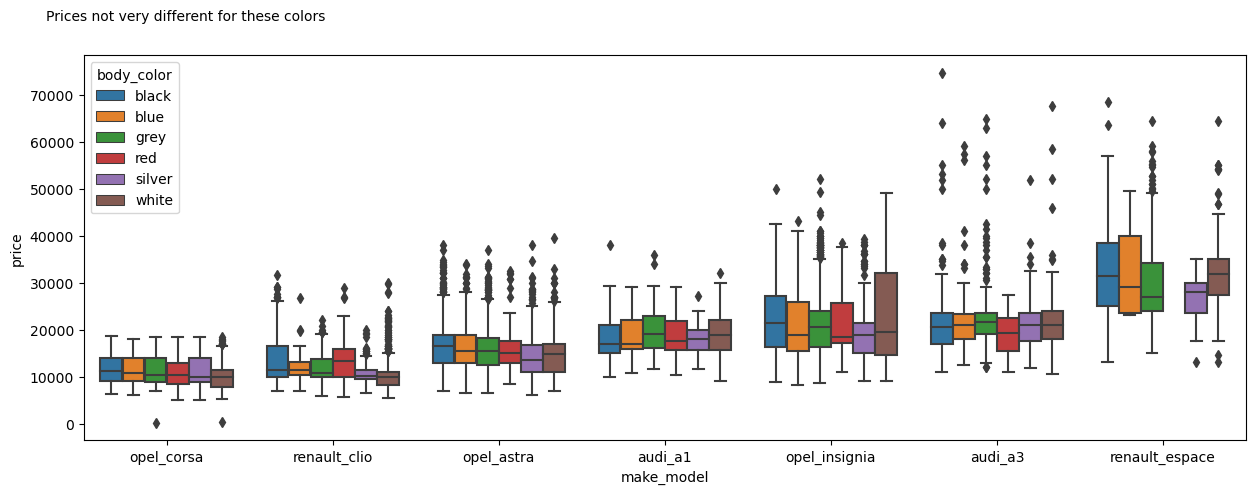

In [30]:
plot_box(df_temp, 'make_model', 'price', 'body_color')
plt.figtext(0.1,.95, "Prices not very different for these colors")

In [31]:
df_temp = df[[x in ['black', 'white', 'blue', 'brown', 'green', 'beige', 'yellow'] for x in df.body_color]]

Text(0.1, 0.95, 'Yellow most expensive')

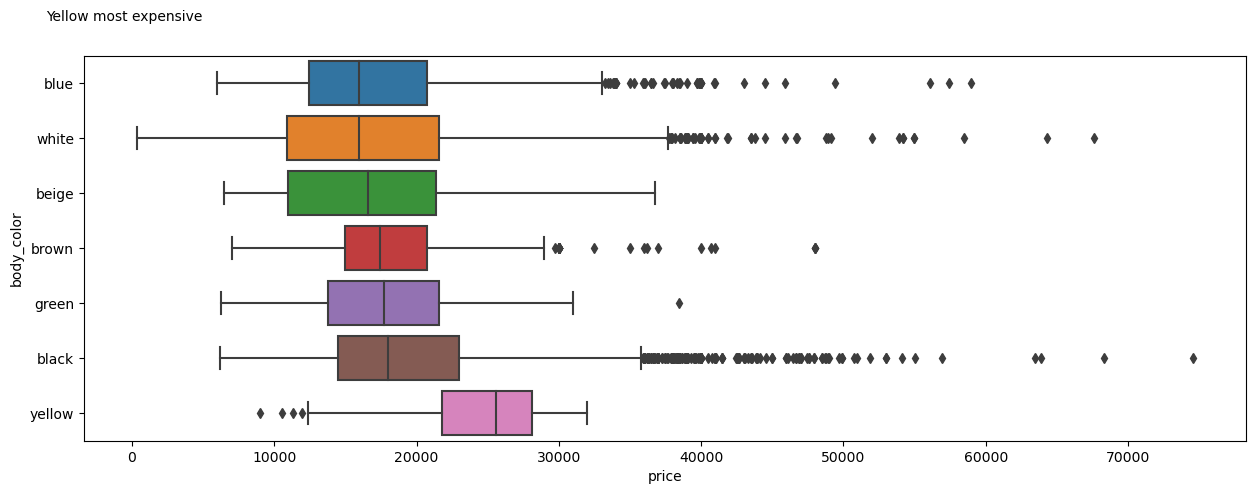

In [32]:
plot_box(df_temp, 'body_color', 'price')
plt.figtext(0.1,.95, "Yellow most expensive")

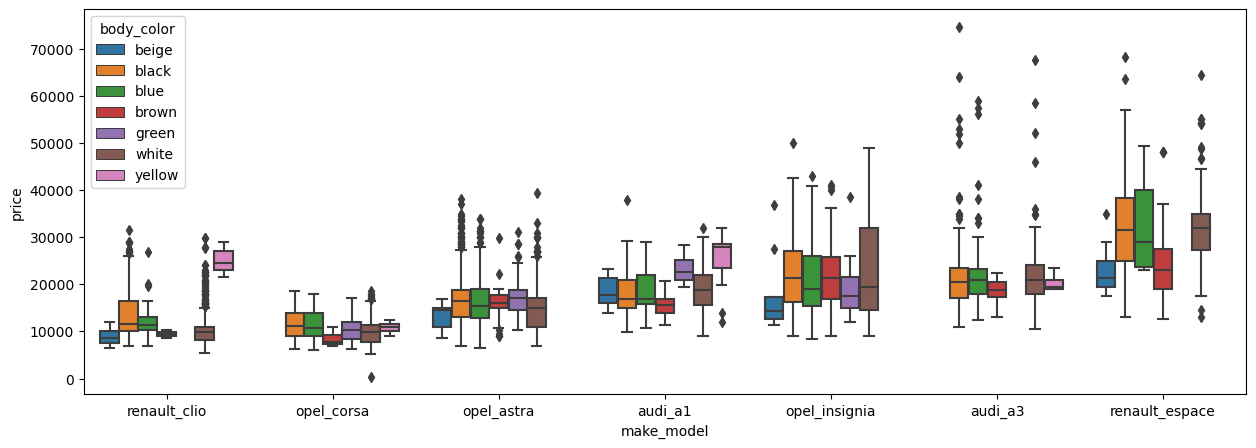

In [33]:
plot_box(df_temp,'make_model','price','body_color')

In [34]:
del df_temp

### hp

In [35]:
df[['hp']].describe()

hp
count  15884.000000
mean      88.396626
std       26.867500
min        1.000000
25%       66.000000
50%       85.000000
75%      103.000000
max      294.000000

<AxesSubplot:ylabel='Frequency'>

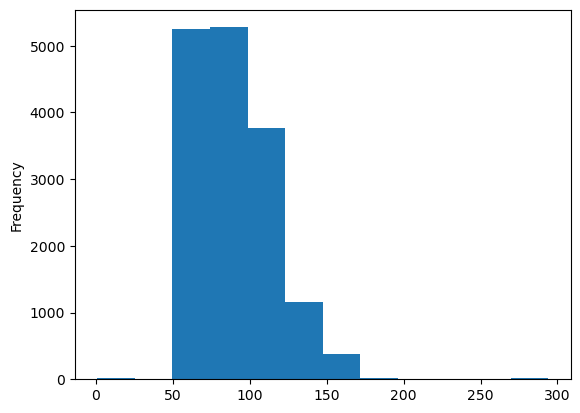

In [36]:
df.hp.plot.hist(bins=12)

In [37]:
df.hp.size, df[(df.hp>=50) & (df.hp<=150)].hp.count(), 

(15884, 15453)

#### price and hp

In [38]:
df['hp_25'] = df.hp // 25
df['hp_25'] = [str(int(x)) for x in df.hp_25]

In [39]:
df.hp_25.value_counts()

3     5276
2     5249
4     3766
5     1160
6      372
0       22
11      18
7       13
9        3
1        3
10       2
Name: hp_25, dtype: int64

Text(0.1, 0.95, 'median price monotonous by hp_25')

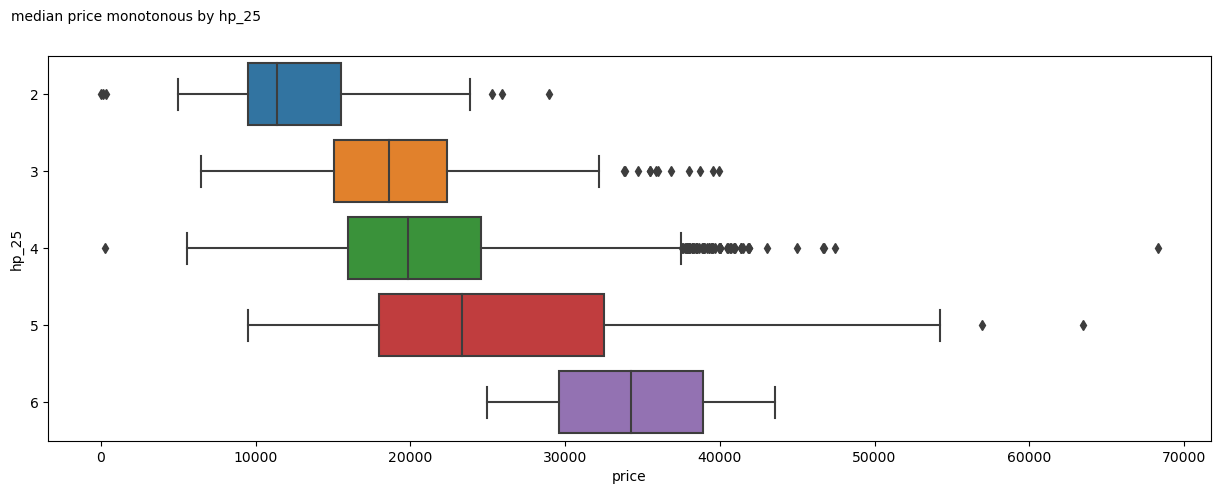

In [40]:
plot_box(df[(df.hp>=50) & (df.hp<=150)],'hp_25','price')
plt.figtext(0.1,.95, "median price monotonous by hp_25")

Text(0.1, 0.95, 'median price monotonous by hp_25')

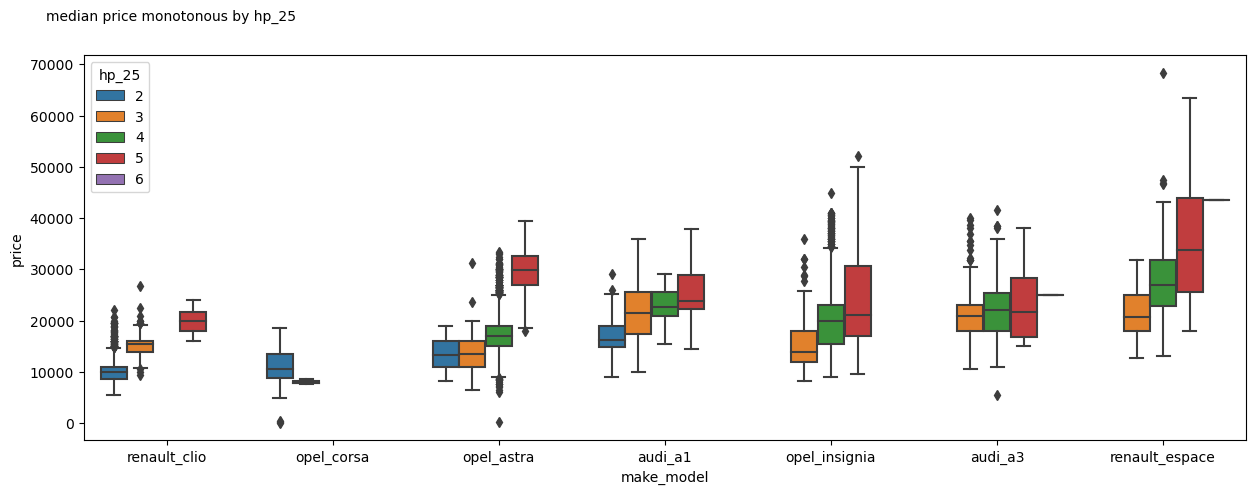

In [41]:
plot_box(df[(df.hp>=50) & (df.hp<=150)],'make_model','price','hp_25')
plt.figtext(0.1,.95, "median price monotonous by hp_25")

In [42]:
df = df.drop('hp_25', axis = 1)

### emission_class

In [43]:
df.emission_class.value_counts()

euro 6          13003
euro 6d-temp     2606
euro 6c           127
euro 5             78
euro 6d            62
euro 4              8
Name: emission_class, dtype: int64

In [44]:
df.groupby('emission_class').first_registration.value_counts()

emission_class  first_registration
euro 4          2016                     3
                2018                     3
                2017                     1
                2019                     1
euro 5          2016                    52
                2017                    16
                2018                     8
                2019                     2
euro 6          2018                  4262
                2016                  3562
                2017                  3200
                2019                  1979
euro 6c         2019                    67
                2018                    48
                2016                     8
                2017                     4
euro 6d         2019                    50
                2018                     8
                2016                     3
                2017                     1
euro 6d-temp    2019                  2317
                2018                   192
                201

In [45]:
df.groupby('make_model').emission_class.value_counts()

make_model      emission_class
audi_a1         euro 6            2319
                euro 6d-temp       278
                euro 5               9
                euro 6d              5
                euro 6c              2
                euro 4               1
audi_a3         euro 6            2647
                euro 6d-temp       436
                euro 5               7
                euro 6d              4
                euro 6c              3
opel_astra      euro 6            1909
                euro 6d-temp       583
                euro 5              14
                euro 6c             13
                euro 6d              7
opel_corsa      euro 6            1536
                euro 6d-temp       637
                euro 6d             27
                euro 6c             10
                euro 5               8
                euro 4               1
opel_insignia   euro 6            1978
                euro 6d-temp       576
                euro 6c          

#### price and emission_class

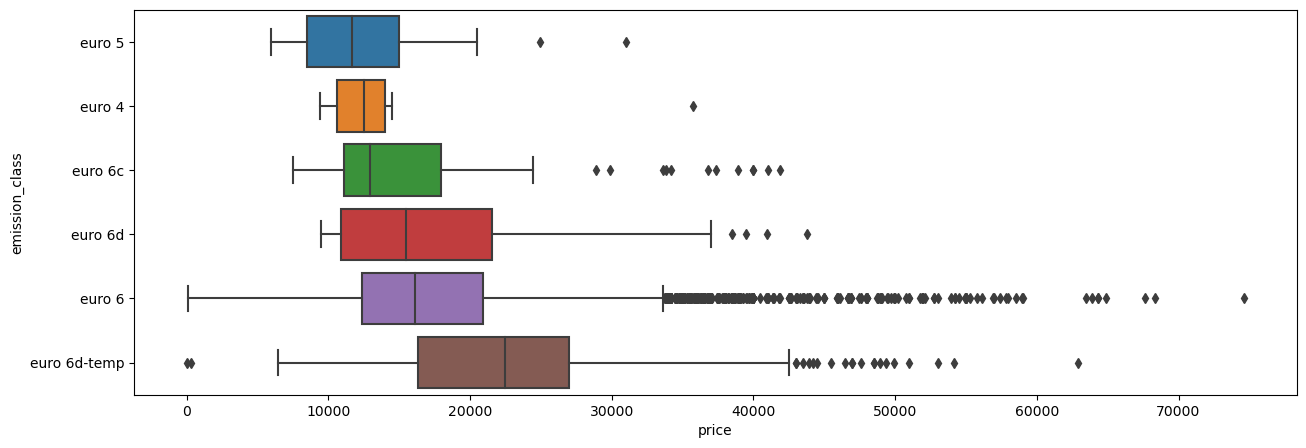

In [46]:
plot_box(df, 'emission_class', 'price')

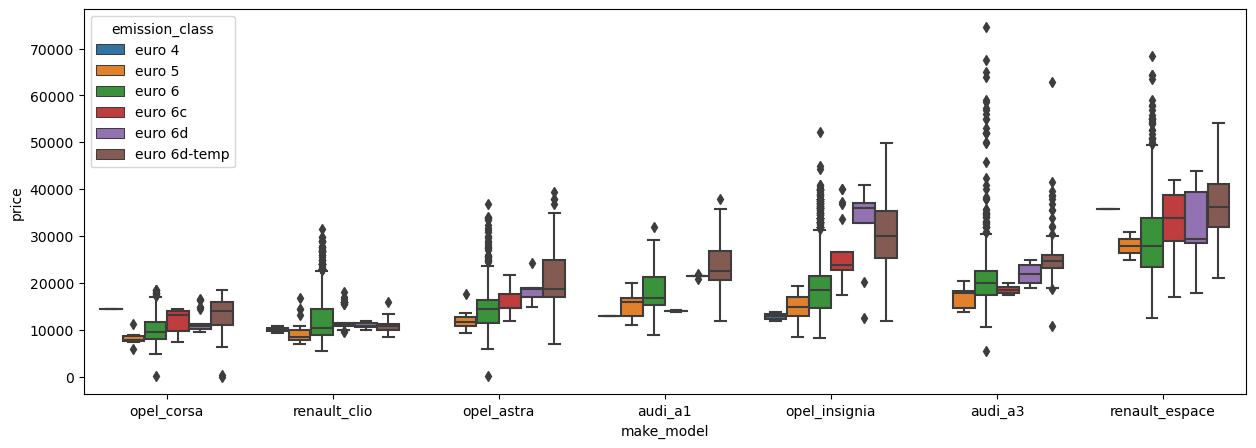

In [47]:
plot_box(df, 'make_model', 'price', 'emission_class')

### gearing_type 

In [48]:
df.gearing_type.value_counts()

manual            8126
automatic         7289
semi-automatic     469
Name: gearing_type, dtype: int64

In [49]:
df.groupby('make_model').gearing_type.value_counts()

make_model      gearing_type  
audi_a1         manual            1405
                automatic         1152
                semi-automatic      57
audi_a3         manual            1477
                automatic         1360
                semi-automatic     260
opel_astra      manual            1415
                automatic         1093
                semi-automatic      18
opel_corsa      manual            1299
                automatic          870
                semi-automatic      50
opel_insignia   automatic         1324
                manual            1274
renault_clio    manual            1174
                automatic          620
                semi-automatic      45
renault_espace  automatic          870
                manual              82
                semi-automatic      39
Name: gearing_type, dtype: int64

#### price and gearing_type

Text(0.1, 0.9, 'automatic more expensive than manual')

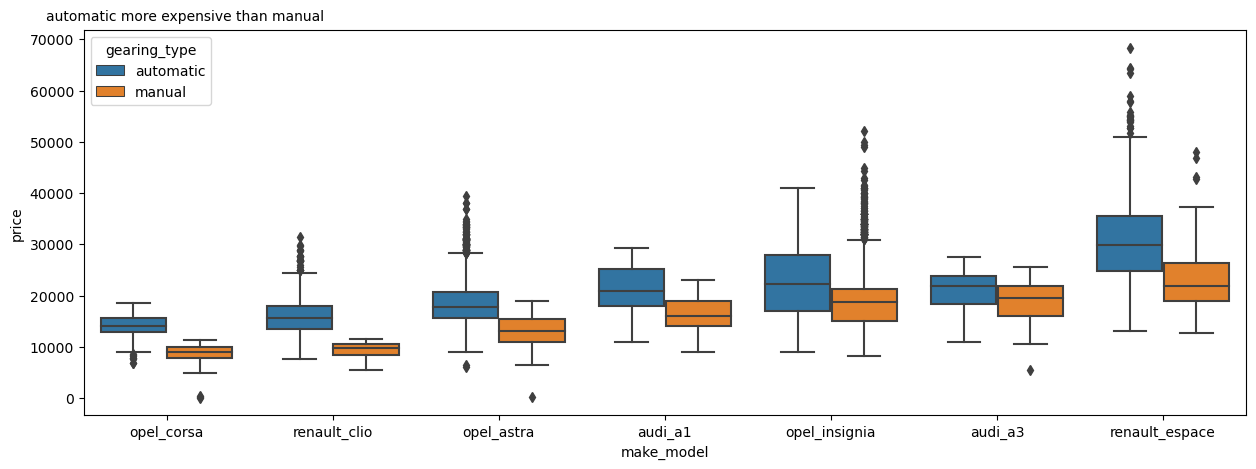

In [50]:
plot_box(df[df.gearing_type != 'semi-automatic'], 'make_model', 'price', 'gearing_type')
plt.figtext(0.1,.9, 'automatic more expensive than manual')

### nr_doors

* All the extreme cases, 1,2, and 7 doors seem plausible. 
* So I will not drop these rows, club them up in fewer classes

In [51]:
df.nr_doors.value_counts()

5    11752
4     3079
3      832
2      219
1        1
7        1
Name: nr_doors, dtype: int64

In [52]:
df[(df.nr_doors==1)|(df.nr_doors==7)]

make_model body_type  price       km  prev_owner   hp  type  \
13781    renault_clio   compact   8500  41493.0           0   55  used   
15167  renault_espace       van  21600  78000.0           0  118  used   

       first_registration body_color paint_type  ...  country_version  \
13781                2016      white   Metallic  ...          Germany   
15167                2016      brown   Metallic  ...          Germany   

       warranty_mo vat_deductible  upholstery_material  upholstery_color  \
13781           12              1                cloth             black   
15167            0              0         full leather             brown   

       emission_class consumption_comb consumption_city  consumption_country  \
13781          euro 6         3.278723         3.561702                  3.1   
15167          euro 6         4.600000         5.000000                  4.4   

          reg_cont  
13781  2016.083333  
15167  2016.333333  

[2 rows x 34 columns]

In [53]:
df[(df.nr_doors==2)|(df.nr_doors==3)].make_model.value_counts()

opel_corsa    597
audi_a1       310
audi_a3       140
opel_astra      4
Name: make_model, dtype: int64

In [54]:
df.loc[df.nr_doors <= 4, 'nr_doors'] = 4
df.loc[df.nr_doors >= 5, 'nr_doors'] = 5

In [55]:
df['nr_doors'] = ["<=4" if x == 4 else ">=5" for x in df.nr_doors]

#### nr_doors and price

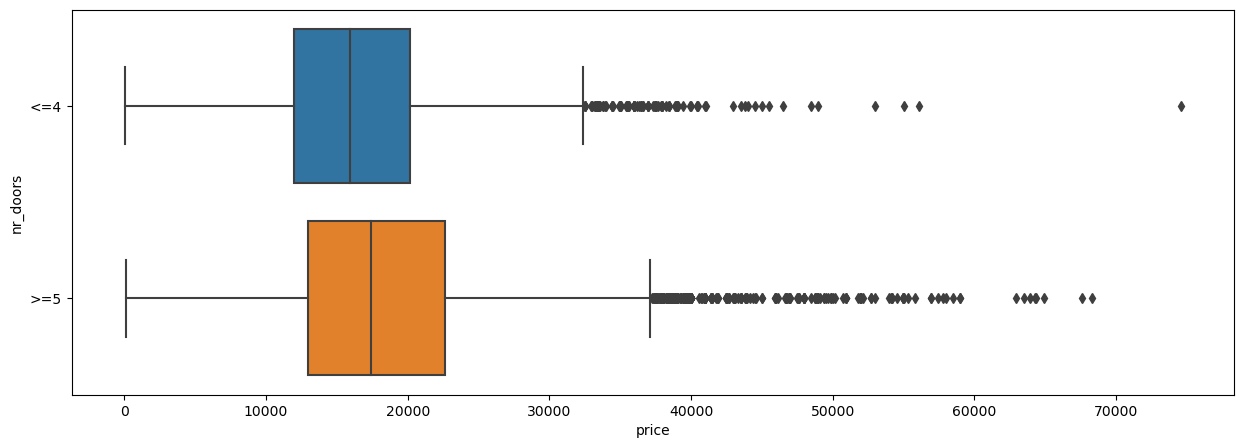

In [56]:
plot_box(df, 'nr_doors', 'price')

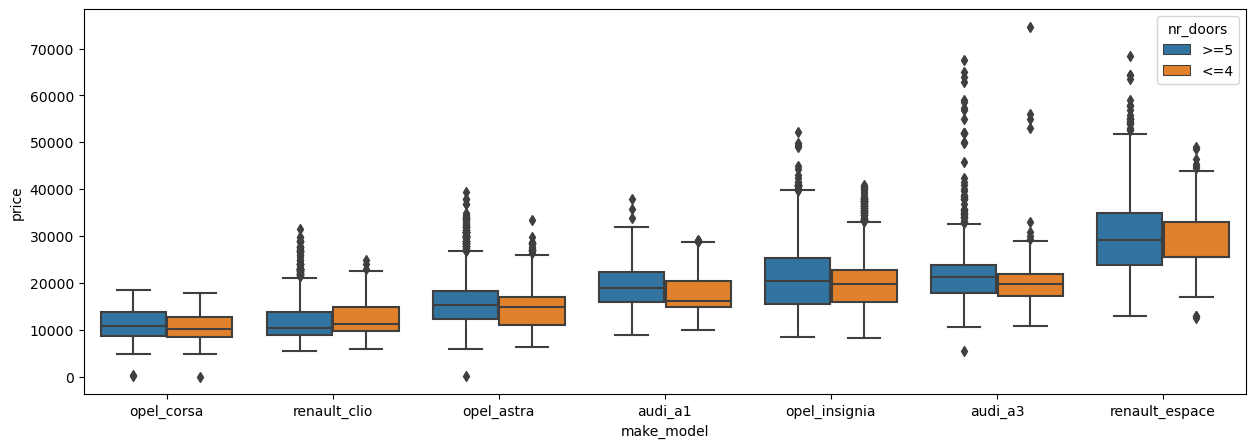

In [57]:
plot_box(df, 'make_model', 'price', 'nr_doors')

### nr_seats

* nr_seats entries seem erroneous. 
* I will club these into two classes <=4 and >=5

In [58]:
df.nr_seats.value_counts()

5    14224
4     1125
7      416
2      116
6        2
3        1
Name: nr_seats, dtype: int64

In [59]:
df[(df.nr_seats==3)][['make_model', 'body_type', 'hp', 'nr_doors']]

make_model body_type   hp nr_doors
1636    audi_a1   compact  141      <=4

In [60]:
df[(df.nr_seats==6)][['make_model', 'body_type', 'hp', 'nr_doors']]

make_model      body_type   hp nr_doors
582           audi_a1        compact   70      >=5
15855  renault_espace  station wagon  147      >=5

In [61]:
df[(df.nr_seats==2)].nr_doors.value_counts()

>=5    108
<=4      8
Name: nr_doors, dtype: int64

In [62]:
df.loc[df.nr_seats <= 4, 'nr_seats'] = 4
df.loc[df.nr_seats >= 5, 'nr_seats'] = 5
df['nr_seats'] = ["<=4" if x == 4 else ">=5" for x in df.nr_seats]

#### nr_seats and price

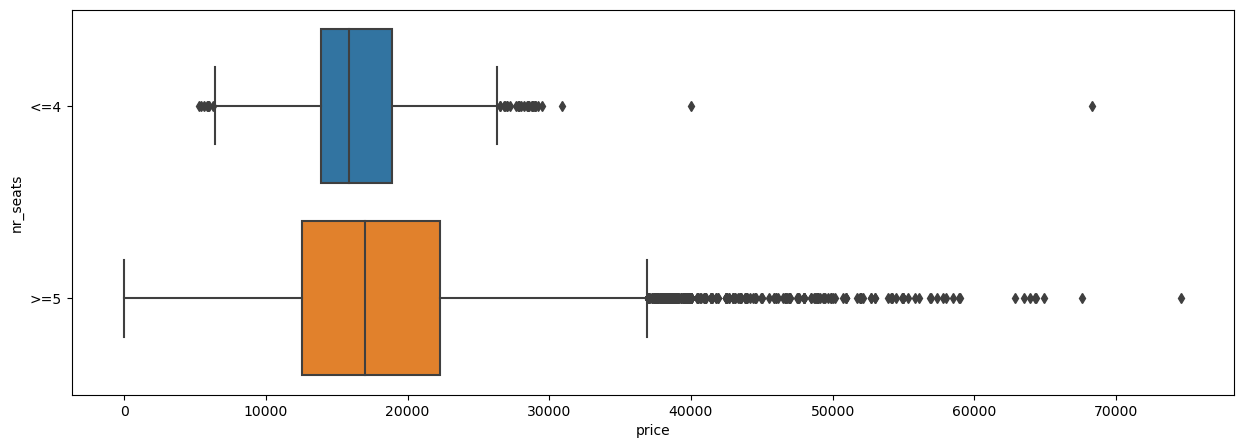

In [63]:
plot_box(df, 'nr_seats', 'price')

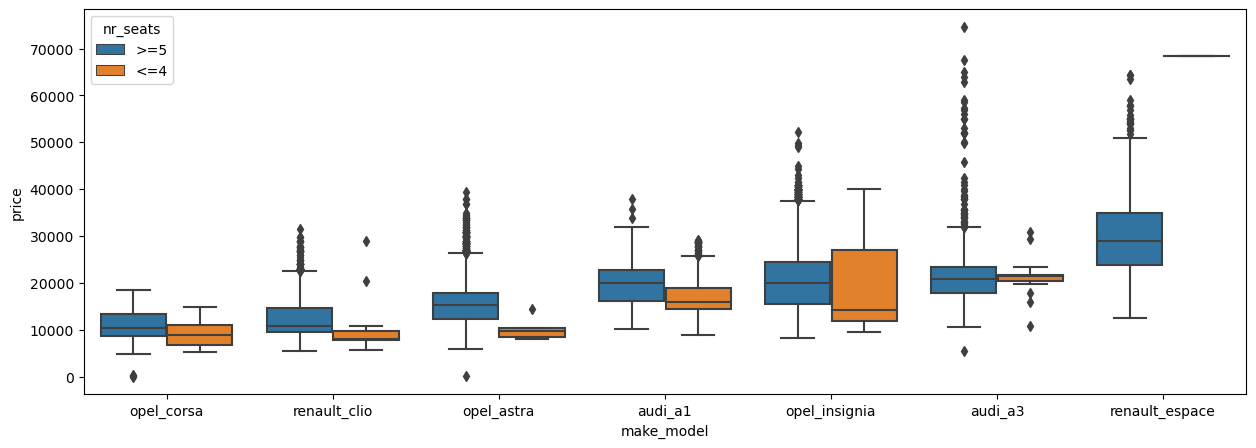

In [64]:
plot_box(df, 'make_model', 'price', 'nr_seats')

### displacement

* from what I gather online displacement is tied to volume of engine cylinders. 
* the continuous spread of displacement seems unwarranted. it should be specific no.s such as 1.6, 1.7, 1.9
* assuing the displacements is in units of ml, displace of less than 800 and above 3000 seem erroneous (wrong units or missing digits)
* for above 15000 I will replace these by removing a zero at the end.
* for the ones below 800, I am going to set as NaN and then impute using mean of the make_model and body_type.


<AxesSubplot:ylabel='Frequency'>

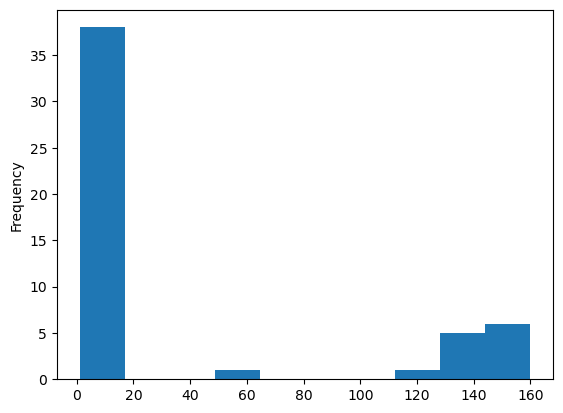

In [65]:
df[df.displacement<800]['displacement'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

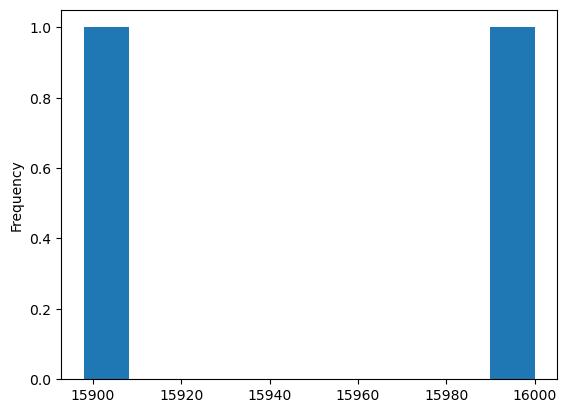

In [66]:
df[df.displacement>3000]['displacement'].plot.hist()

In [67]:
df.loc[df.displacement>3000, 'displacement'] = df['displacement'] // 10

In [68]:
df.loc[df.displacement<800, 'displacement'] = np.nan

In [69]:
df['for_disp'] = df.groupby(['make_model', 'body_type']).ngroup()

In [70]:
df = fill(df, 'displacement', 'for_disp', 'median')

<AxesSubplot:xlabel='displacement', ylabel='Density'>

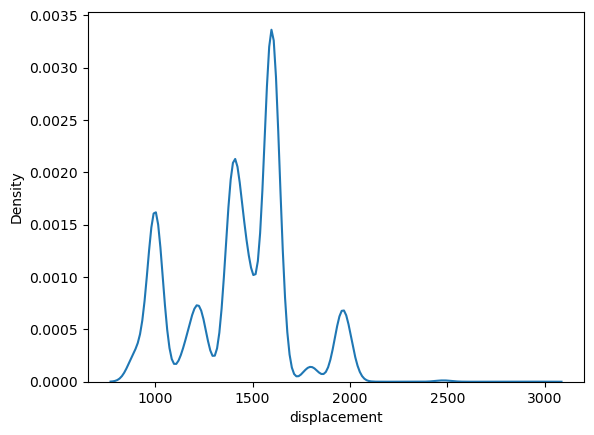

In [71]:
sns.kdeplot(df.displacement)

#### displacement and price

* weak correlaction between displacement and price. 

In [72]:
df[['displacement', 'price']].corr()

displacement     price
displacement      1.000000  0.287345
price             0.287345  1.000000

In [73]:
df['disp_class'] = [ str(round(x*2//1000))  for x in df.displacement]

In [74]:
df['disp_class'].value_counts()

3    6733
2    6161
1    2923
4      66
5       1
Name: disp_class, dtype: int64

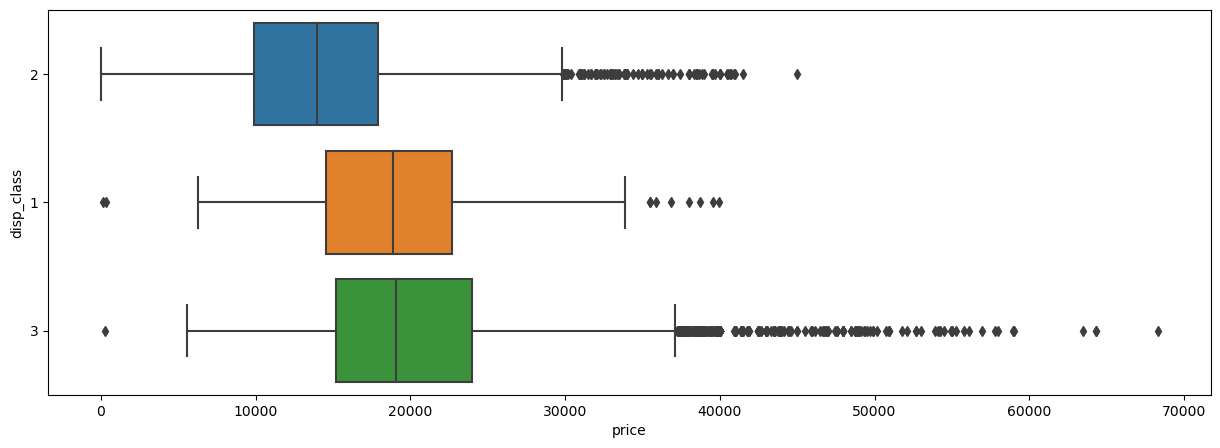

In [75]:
plot_box(df[(df.disp_class != '4') & (df.disp_class != '5')], 'disp_class', 'price')

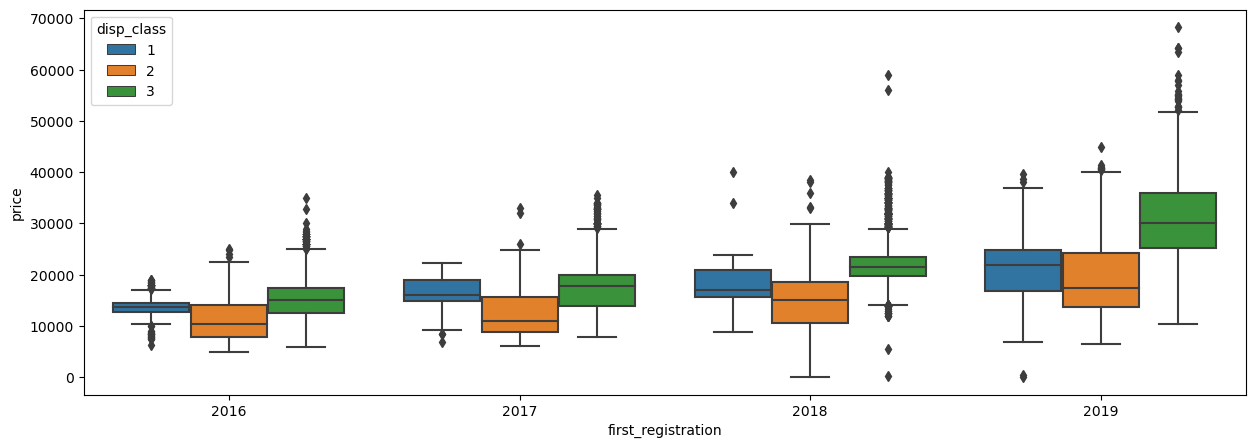

In [76]:
plot_box(df[(df.disp_class != '4') & (df.disp_class != '5')], 'first_registration', 'price', 'disp_class')

In [77]:
df = df.drop(['for_disp', 'disp_class'], axis=1)

### cylinders

In [78]:
df.cylinders.value_counts()

4    12891
3     2963
5       22
6        3
8        2
2        2
1        1
Name: cylinders, dtype: int64

In [79]:
df.loc[df.cylinders <= 3, 'cylinders'] = 3
df.loc[df.cylinders >= 4, 'cylinders'] = 4
df['cylinders'] = ["<=3" if x == 3 else ">=4" for x in df.cylinders]

In [80]:
df.cylinders.value_counts(dropna=False)

>=4    12918
<=3     2966
Name: cylinders, dtype: int64

#### cylinders and price

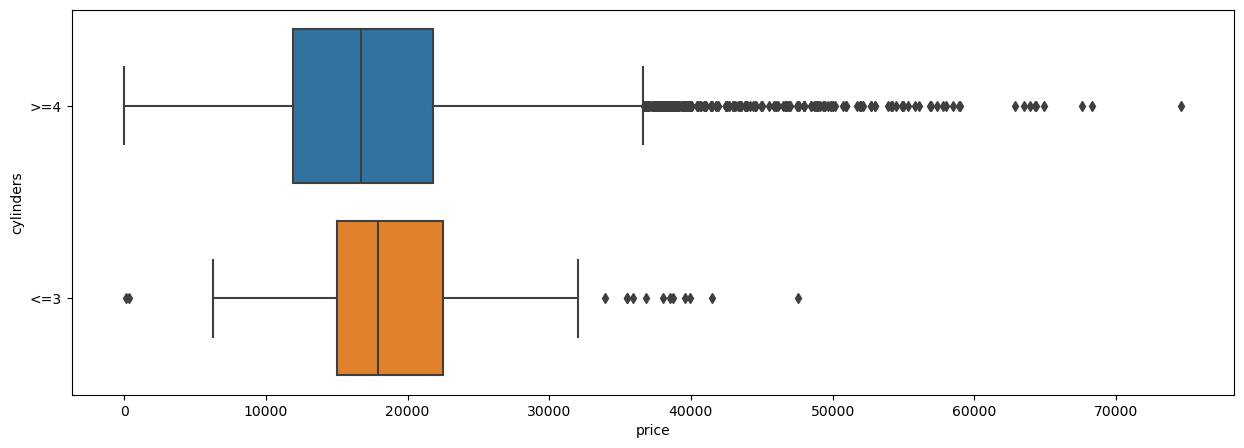

In [81]:
plot_box(df, 'cylinders', 'price')

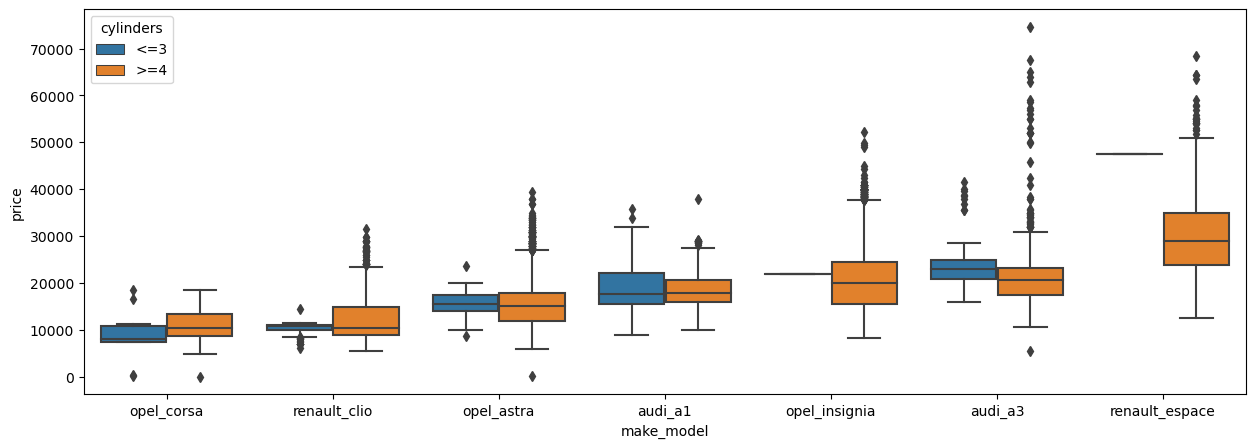

In [82]:
plot_box(df, 'make_model', 'price', 'cylinders')

### weight

* weight of 1 is non-sense in the context, I will assume it's unit is tonne (1000kg)

<AxesSubplot:ylabel='Frequency'>

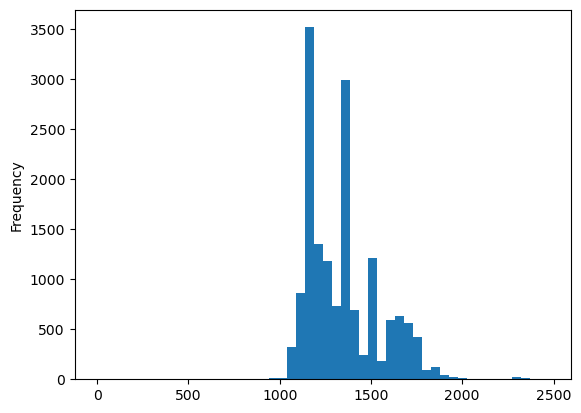

In [83]:
df.weight.plot.hist(bins=50)

In [84]:
df[df.weight<1000].weight.value_counts()

980.0    11
1.0       2
977.0     2
102.0     1
840.0     1
900.0     1
Name: weight, dtype: int64

In [85]:
df.loc[df.weight==1,'weight'] = 1000

In [86]:
df.loc[df.weight==102,'weight'] = 1020

In [87]:
df[df.weight>2000].weight.value_counts()

2353.0    15
2300.0    12
2471.0     5
2410.0     4
2320.0     2
2450.0     2
2400.0     2
2280.0     2
2080.0     1
2044.0     1
2115.0     1
2240.0     1
2355.0     1
2270.0     1
2275.0     1
2110.0     1
2295.0     1
2037.0     1
Name: weight, dtype: int64

#### weight and price

* weak positive correlation

In [88]:
df[['weight', 'price']].corr()

weight     price
weight  1.000000  0.445854
price   0.445854  1.000000

In [89]:
df['wt_class'] = [int(x*5//1000) for x in df['weight']]

In [90]:
df['wt_class'].value_counts()

6     5779
5     5621
8     2156
7     1997
9      256
11      36
4       15
12      13
10      11
Name: wt_class, dtype: int64

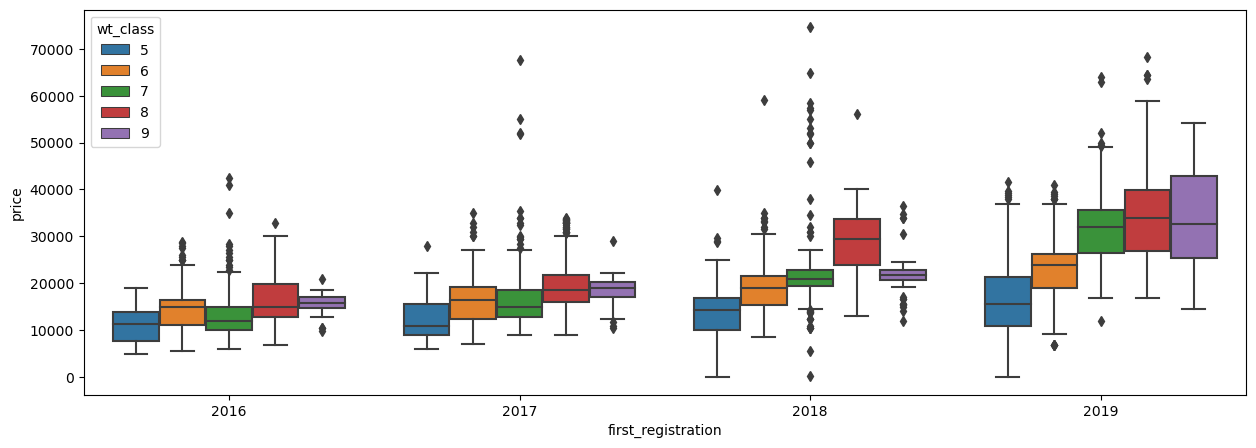

In [91]:
plot_box(df[(df.wt_class>4) & (df.wt_class<10)], 'first_registration', 'price', 'wt_class')
# ignoring about 75 rows

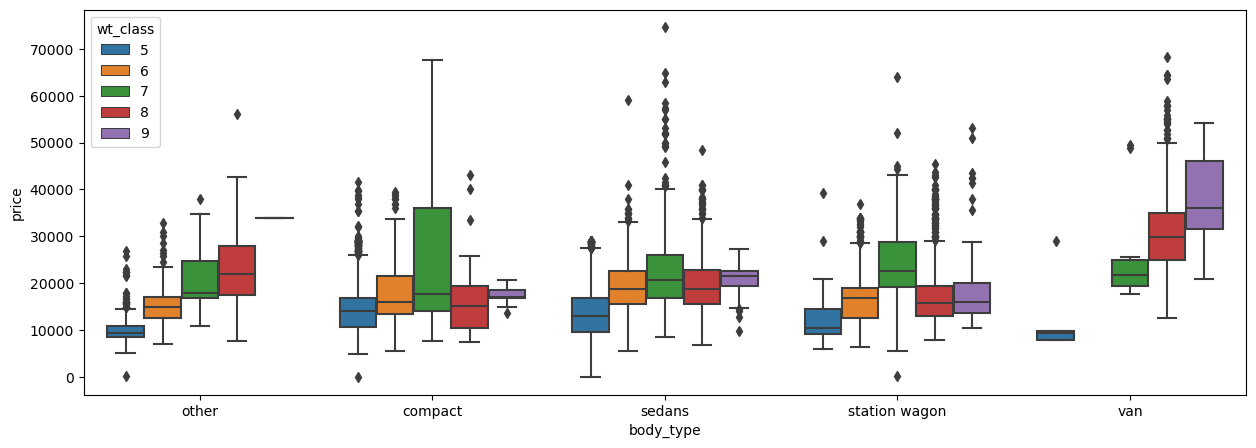

In [92]:
plot_box(df[(df.wt_class>4) & (df.wt_class<10)], 'body_type', 'price', 'wt_class')

In [93]:
df = df.drop('wt_class', axis=1)

### drive_chain

In [94]:
df.drive_chain.value_counts()

front    15604
4WD        280
Name: drive_chain, dtype: int64

#### drive_chain and price

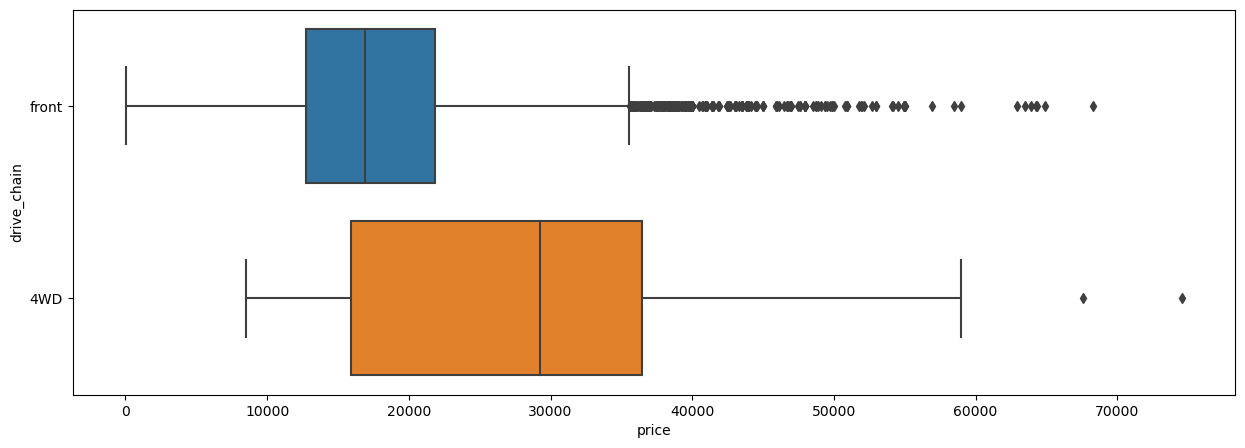

In [95]:
plot_box(df, 'drive_chain', 'price')

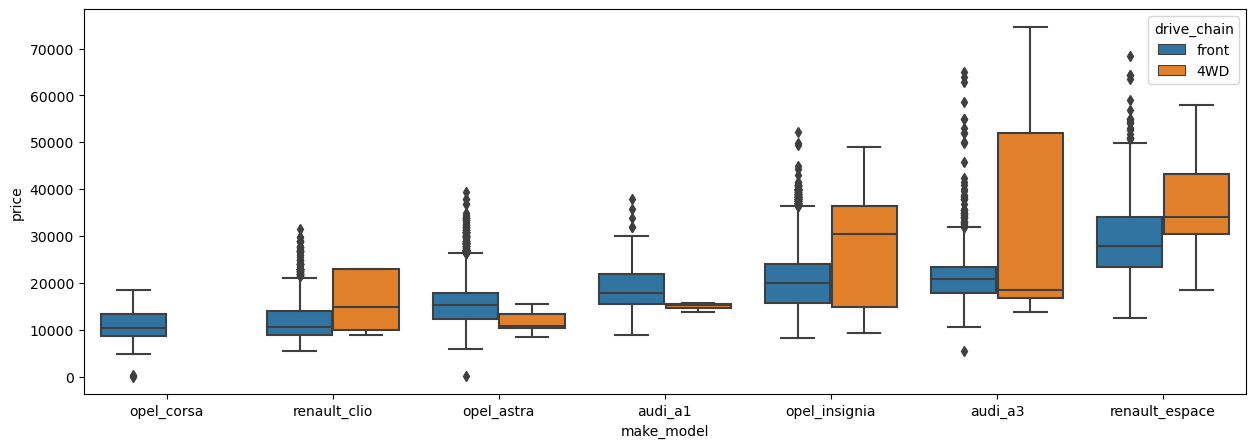

In [96]:
plot_box(df, 'make_model', 'price', 'drive_chain')

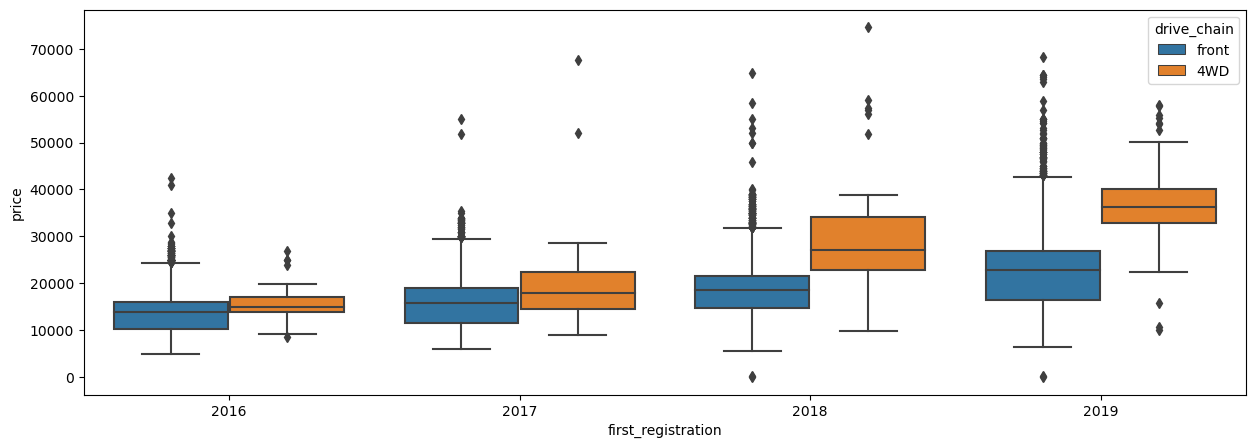

In [97]:
plot_box(df, 'first_registration','price','drive_chain')

### fuel

In [98]:
df.fuel.value_counts()

gas       8510
diesel    7298
other       76
Name: fuel, dtype: int64

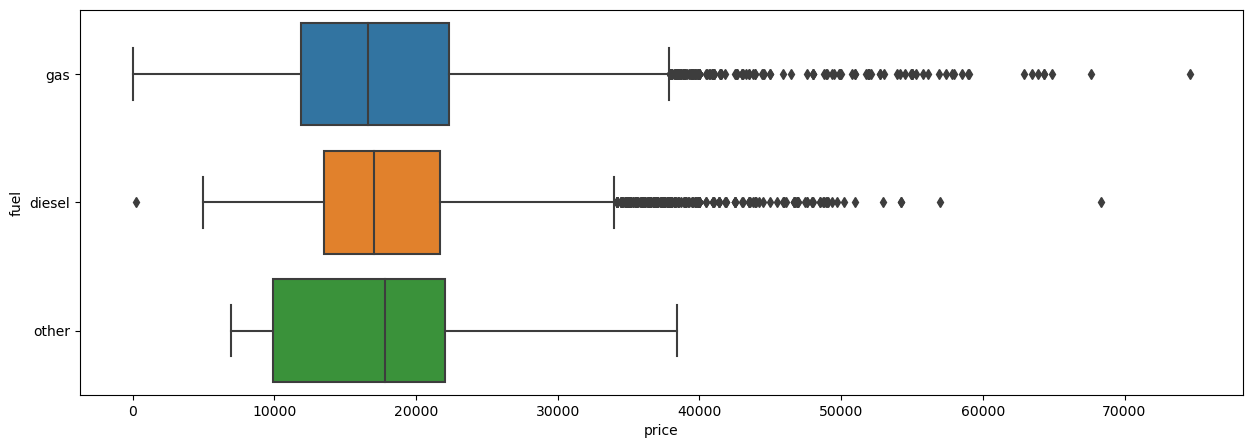

In [99]:
plot_box(df, 'fuel', 'price')

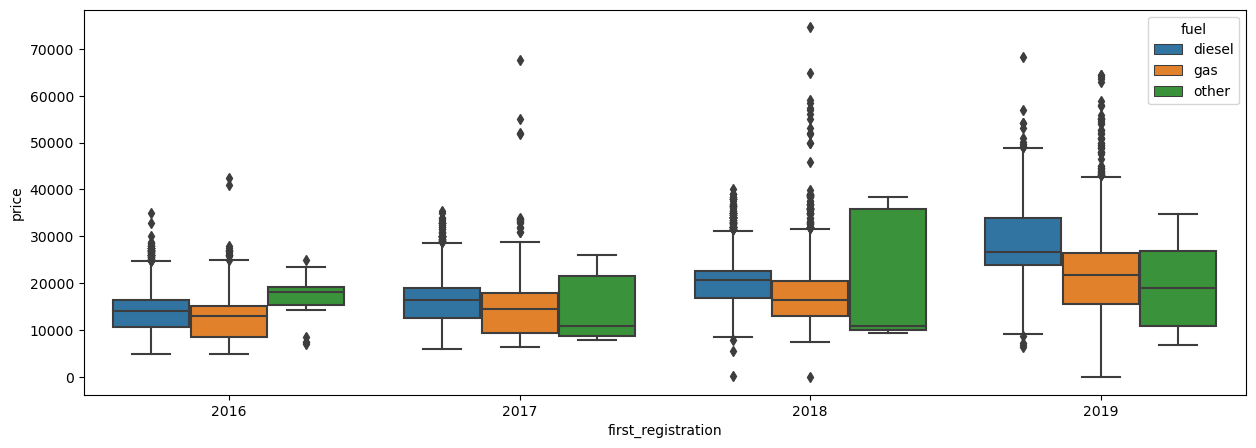

In [100]:
plot_box(df, 'first_registration', 'price', 'fuel')

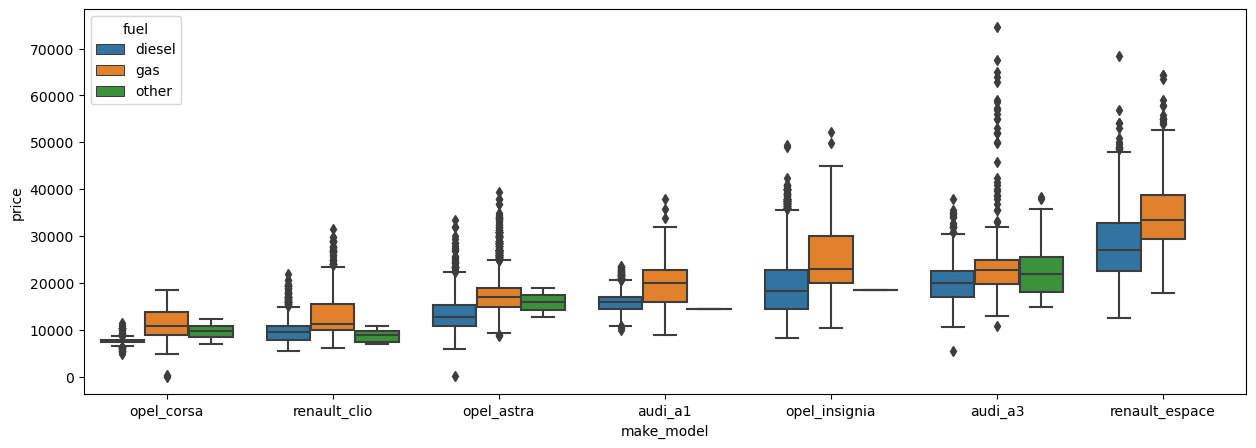

In [101]:
plot_box(df, 'make_model', 'price', 'fuel')

### co2_emission

* 95 - 115 g/km is a reasonable range for co2 emission by european standards.
* I will replace amounts > 200 with NaN and then impute with medians within make_model, fuel and first_registration

In [102]:
df[['co2_emission']].describe()

co2_emission
count  15884.000000
mean     122.316230
std      248.820827
min        0.000000
25%      104.000000
50%      116.000000
75%      128.000000
max    14457.000000

In [103]:
df[df.co2_emission>200].co2_emission.value_counts()

12087    3
331      1
1060     1
990      1
12324    1
253      1
239      1
14457    1
13983    1
Name: co2_emission, dtype: int64

In [104]:
df.loc[df.co2_emission>200,'co2_emission'] = np.nan

In [105]:
df['for_e'] = df.groupby(['make_model','fuel','first_registration']).ngroup()

In [106]:
df.gears.value_counts(dropna=False)

6     8375
5     5363
7     1908
8      224
9        6
1        2
3        2
4        2
2        1
50       1
Name: gears, dtype: int64

In [107]:
df = fill(df,'co2_emission','for_e','median')

In [108]:
df=df.drop('for_e', axis=1)

### gears

* for renault escape https://en.wikipedia.org/wiki/Renault_Espace
    * automatic have 6 or 7 gears
    * manuals have 6 gears always
* for renault clio https://en.wikipedia.org/wiki/Renault_Clio
    * manuals always have 5 gears always
    * automatic have 5 or 6 gears
    

In [109]:
df.gears.value_counts(dropna=False)

6     8375
5     5363
7     1908
8      224
9        6
1        2
3        2
4        2
2        1
50       1
Name: gears, dtype: int64

In [110]:
df[(df.gears>8)|(df.gears<5)][['make_model', 'price', 'type', 'body_type','gears','gearing_type']]

make_model  price            type body_type  gears    gearing_type
8920       opel_corsa  11000            used   compact      1  semi-automatic
9811       opel_corsa   9880            used    sedans      2          manual
14374    renault_clio  23990   demonstration   compact      1       automatic
14494    renault_clio  10798  pre_registered    sedans     50          manual
15777  renault_espace  54982             new       van      9       automatic
15779  renault_espace  54982             new       van      9       automatic
15782  renault_espace  54204             new       van      3       automatic
15787  renault_espace  50950             new       van      4       automatic
15788  renault_espace  50950             new       van      4       automatic
15789  renault_espace  52711             new       van      9       automatic
15792  renault_espace  52711             new       van      9       automatic
15810  renault_espace  46660             new       van      3       automatic
15834  renault_espace  49100             new       van      9       automatic
15841  renault_espace  48765             new       van      9       automatic

In [111]:
df[df.make_model=='renault_espace'].gears.value_counts()

6    844
7    135
9      6
5      2
3      2
4      2
Name: gears, dtype: int64

In [112]:
df[(df.make_model=='renault_espace')&(df.gearing_type=='manual')].gears.value_counts()

6    80
7     2
Name: gears, dtype: int64

In [113]:
df.loc[(df.make_model=='renault_espace')&(df.gearing_type=='manual')&(df.gears==7),'gears'] = 6

In [114]:
df[(df.make_model=='renault_espace')&(df.gearing_type=='automatic')].gears.value_counts()

6    726
7    132
9      6
5      2
3      2
4      2
Name: gears, dtype: int64

In [115]:
df.loc[(df.make_model=='renault_espace')&(df.gearing_type=='automatic'),'gears'] = \
    [choices((6,7), weights=(726,132))[0] if (x<6 or x>7) else x for x in \
             df[(df.make_model=='renault_espace')&(df.gearing_type=='automatic')].gears]

In [116]:
df[(df.make_model=='renault_espace')&(df.gearing_type=='automatic')].gears.value_counts()

6    736
7    134
Name: gears, dtype: int64

In [117]:
df[(df.gears==1)|(df.gears==2)|(df.gears==50)][['make_model','gearing_type', 'first_registration', 'type','gears']]

make_model    gearing_type  first_registration            type  gears
8920     opel_corsa  semi-automatic                2018            used      1
9811     opel_corsa          manual                2018            used      2
14374  renault_clio       automatic                2018   demonstration      1
14494  renault_clio          manual                2019  pre_registered     50

In [118]:
df[df.make_model=='renault_clio'].gears.value_counts()

5     1443
6      391
7        3
1        1
50       1
Name: gears, dtype: int64

In [119]:
df[(df.make_model=='renault_clio')&(df.gearing_type=='automatic')].gears.value_counts()

6    335
5    281
7      3
1      1
Name: gears, dtype: int64

In [120]:
df[(df.make_model=='renault_clio')&(df.gearing_type=='manual')].gears.value_counts()

5     1162
6       11
50       1
Name: gears, dtype: int64

In [121]:
df.loc[(df.make_model=='renault_clio')&(df.gearing_type=='manual')&(df.gears>5),'gears'] = 5

In [122]:
df.loc[(df.make_model=='renault_clio')&(df.gearing_type=='automatic')&((df.gears>6)|(df.gears<5)),'gears'] = \
[choices((6, 5), weights=(335,281)) for x in \
   df[(df.make_model=='renault_clio')&(df.gearing_type=='automatic')&((df.gears>6)|(df.gears<5))].gears]

In [123]:
df[df.make_model=='renault_clio'].gears.value_counts(dropna=False)

5    1456
6     383
Name: gears, dtype: int64

In [124]:
df[df.make_model=='opel_corsa'].gears.value_counts()

5    1754
6     462
1       1
2       1
8       1
Name: gears, dtype: int64

In [125]:
df.loc[(df.make_model=='opel_corsa')&((df.gears>6)|(df.gears<5)),'gears'] = 5

In [126]:
df.gears.value_counts(dropna=False)

6    8379
5    5377
7    1905
8     223
Name: gears, dtype: int64

In [127]:
df['gears_str'] = df.gears.astype(str)

#### gears and price

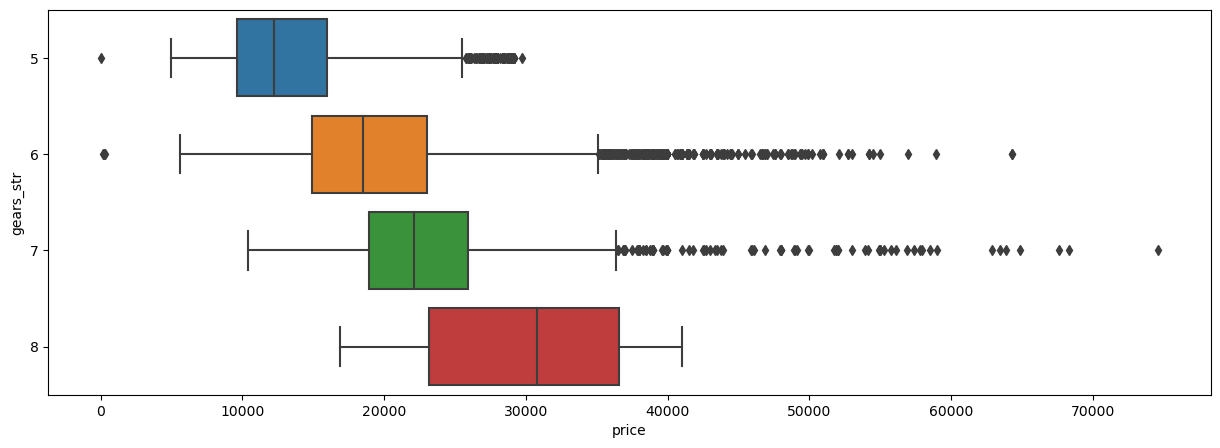

In [128]:
plot_box(df, 'gears_str', 'price')

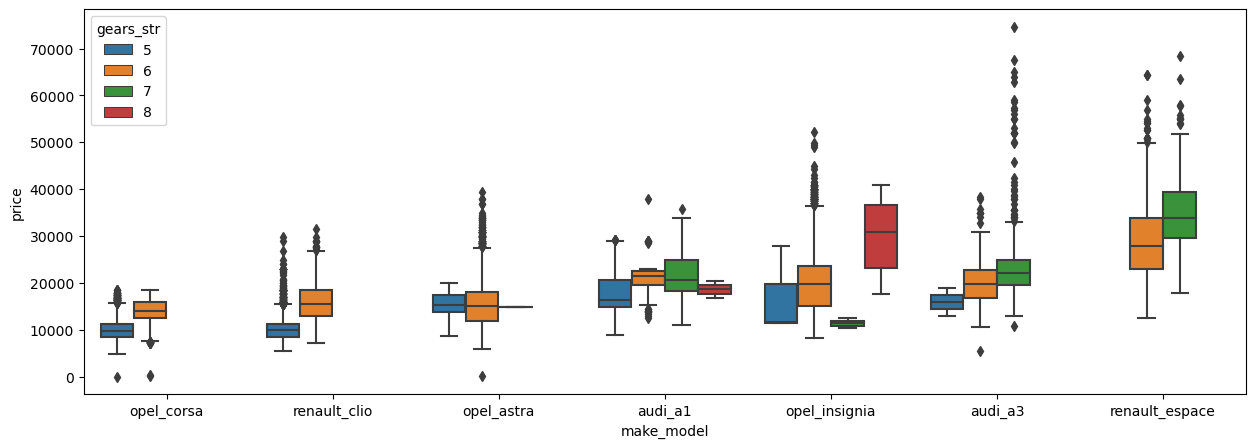

In [129]:
plot_box(df, 'make_model', 'price','gears_str')

### country_version

In [130]:
df.country_version.value_counts()

Germany           10768
Italy              2746
Netherlands         741
European Union      507
Spain               325
Belgium             313
Austria             264
Czech Republic       52
Poland               49
France               38
Denmark              33
Hungary              28
Slovakia              4
Croatia               4
Sweden                3
Romania               2
Bulgaria              2
Luxembourg            1
Switzerland           1
Slovenia              1
Egypt                 1
Serbia                1
Name: country_version, dtype: int64

In [131]:
vc = df.country_version.value_counts()
index = vc.index

In [132]:
set_other = set()
for i in range(len(vc)):
    if vc[i] < 100:
        set_other.add(index[i])
print(set_other)

{'Hungary', 'Romania', 'Egypt', 'Czech Republic', 'Sweden', 'Switzerland', 'Slovenia', 'Serbia', 'Luxembourg', 'France', 'Slovakia', 'Croatia', 'Bulgaria', 'Poland', 'Denmark'}


In [133]:
df['country_version'] = ['other' if x in set_other else x for x in df.country_version]

In [134]:
df['country_version'].value_counts()

Germany           10768
Italy              2746
Netherlands         741
European Union      507
Spain               325
Belgium             313
Austria             264
other               220
Name: country_version, dtype: int64

#### country_version and price

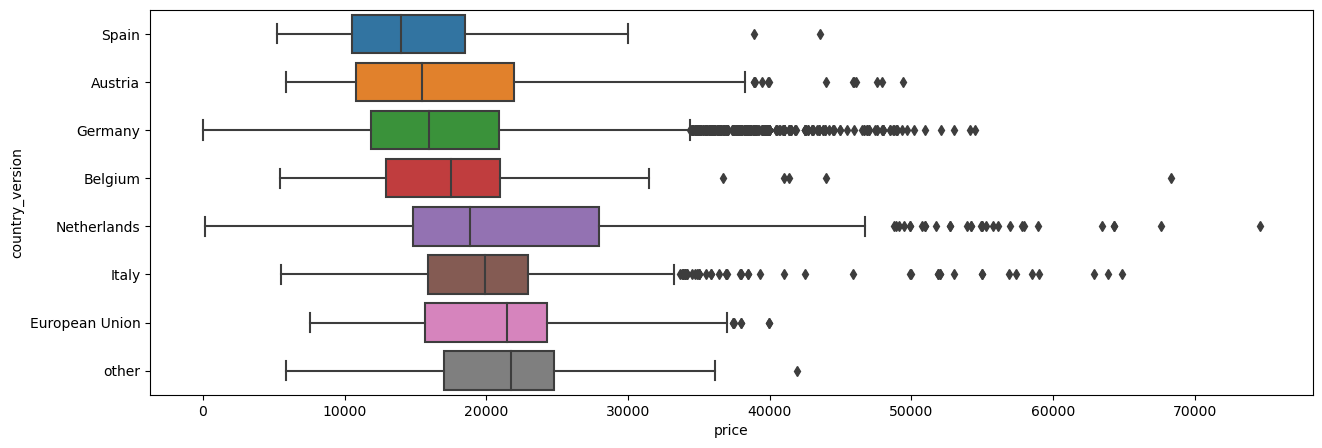

In [135]:
plot_box(df,'country_version','price')

### warranty_mo

<AxesSubplot:ylabel='Frequency'>

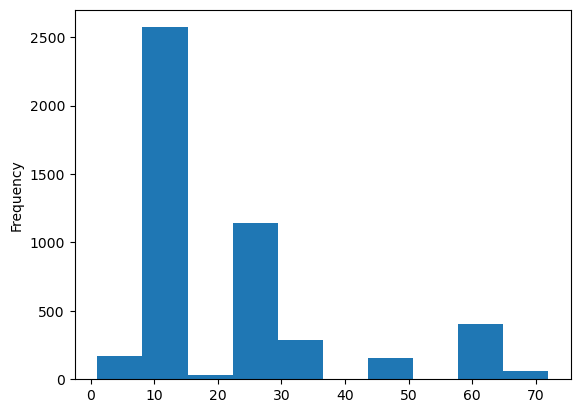

In [136]:
df[df.warranty_mo>0].warranty_mo.plot.hist(bins = 10)

In [137]:
df[df.warranty_mo>0].type.value_counts(dropna=False)

used              3706
pre_registered     360
new                313
employees_car      260
demonstration      182
Name: type, dtype: int64

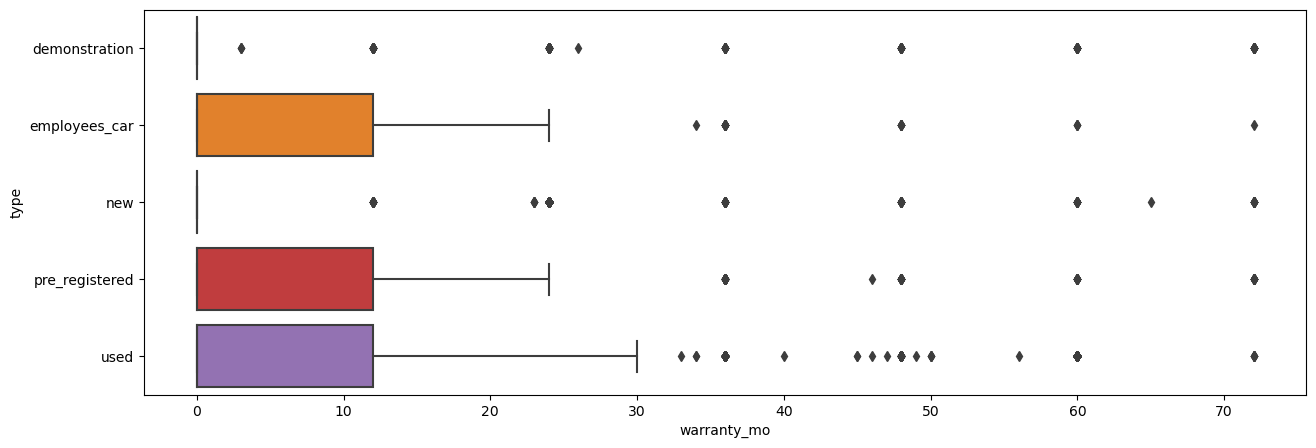

In [138]:
plot_box(df, 'type','warranty_mo')

In [139]:
df['year_str'] = df['first_registration'].astype(str)

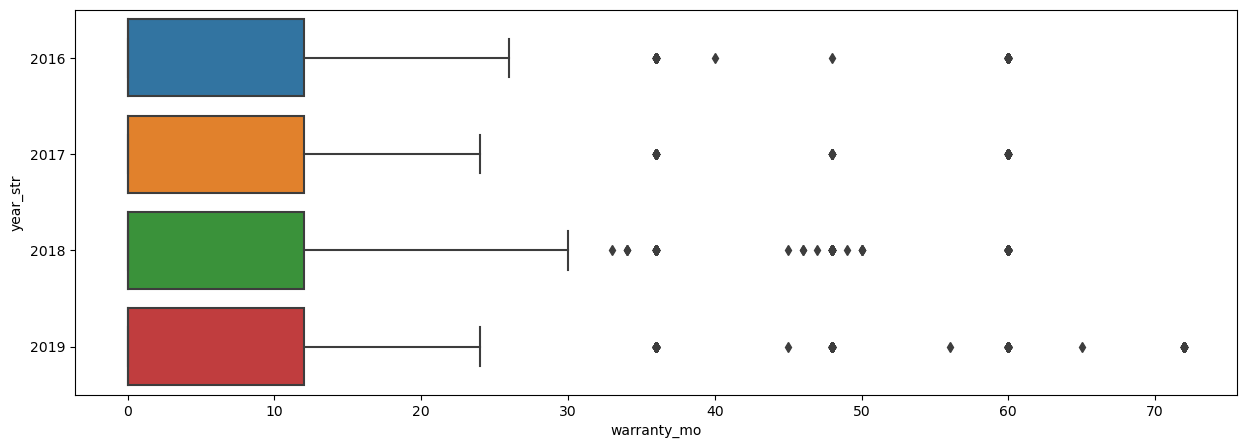

In [140]:
plot_box(df, 'year_str','warranty_mo')

In [141]:
df[df.warranty_mo>30].warranty_mo.count()

905

In [142]:
df = df.drop('year_str', axis = 1)

#### warranty_mo and price

* weak correlation

In [143]:
df[['warranty_mo','price']].corr()

warranty_mo     price
warranty_mo     1.000000  0.035396
price           0.035396  1.000000

In [144]:
df['waranty_yr'] = [str(int(x//12)) for x in df.warranty_mo]

In [145]:
df['waranty_yr'].value_counts()

0    11239
1     2609
2     1135
5      402
3      285
4      155
6       59
Name: waranty_yr, dtype: int64

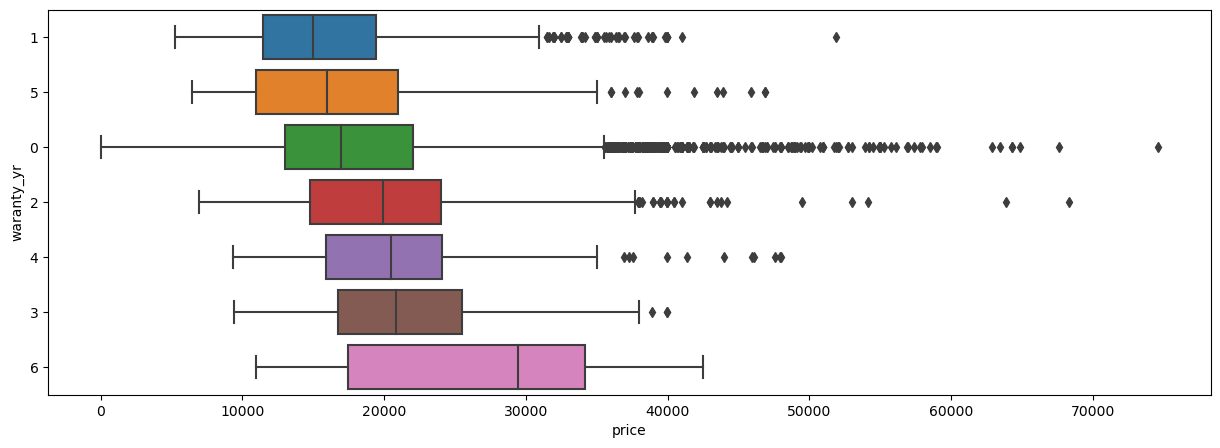

In [146]:
plot_box(df, 'waranty_yr', 'price')

In [147]:
df = df.drop('waranty_yr', axis=1)

### vat_deductible

* should affect prices directly

In [148]:
df.vat_deductible.value_counts()

1    10963
0     4921
Name: vat_deductible, dtype: int64

In [149]:
df['vat'] = df['vat_deductible'].astype(str)

#### vat_deductible and price
* unexpected, cheaper cars are not vat deductible

Text(0.1, 0.95, 'cheaper cars are not vat deductible')

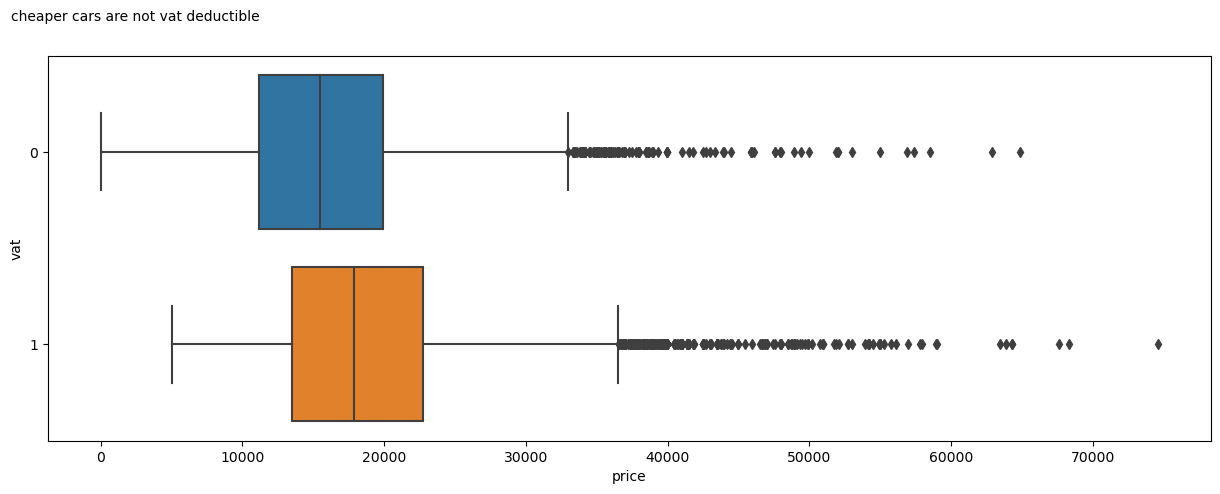

In [150]:
plot_box(df, 'vat', 'price')
plt.figtext(0.1,0.95,'cheaper cars are not vat deductible')

Text(0.1, 0.95, 'cheaper cars are not vat deductible')

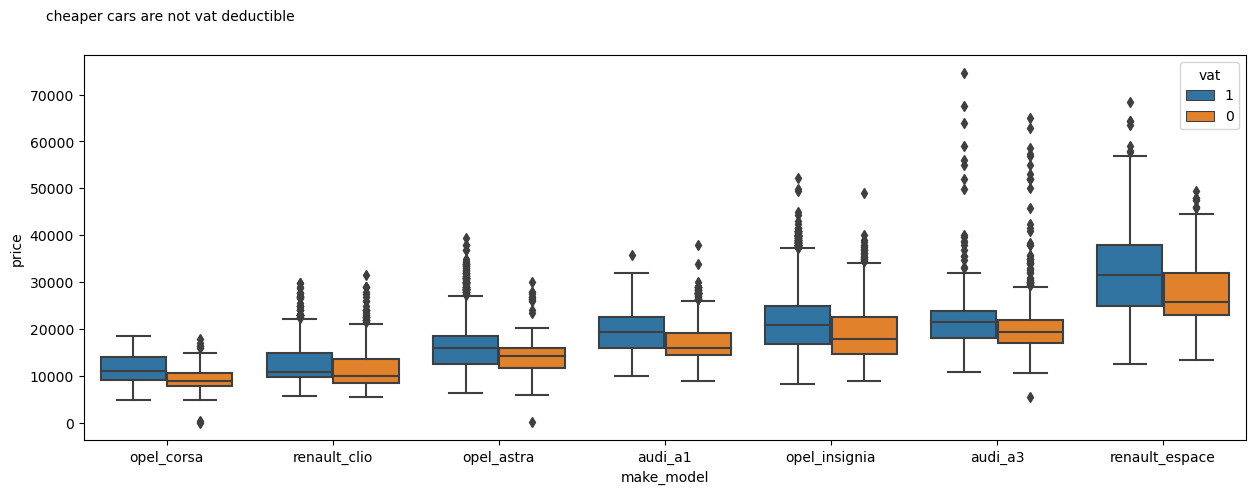

In [151]:
plot_box(df, 'make_model', 'price', 'vat')
plt.figtext(0.1,0.95,'cheaper cars are not vat deductible')

### upholstery_material

In [152]:
df.upholstery_material.value_counts()

cloth           12878
part leather     1501
full leather     1020
other             368
velour             60
alcantara          57
Name: upholstery_material, dtype: int64

#### upholstery_material and price

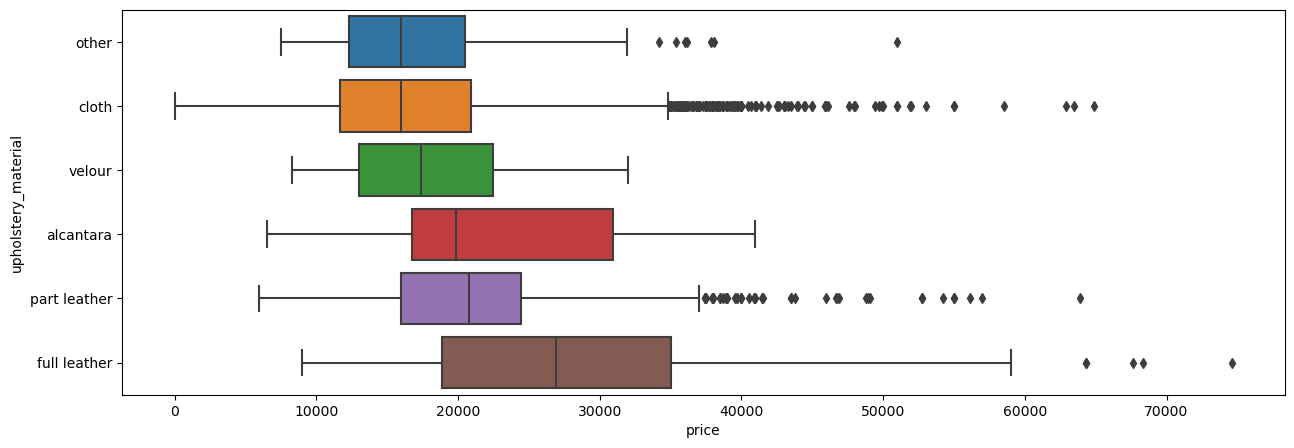

In [153]:
plot_box(df,'upholstery_material','price')

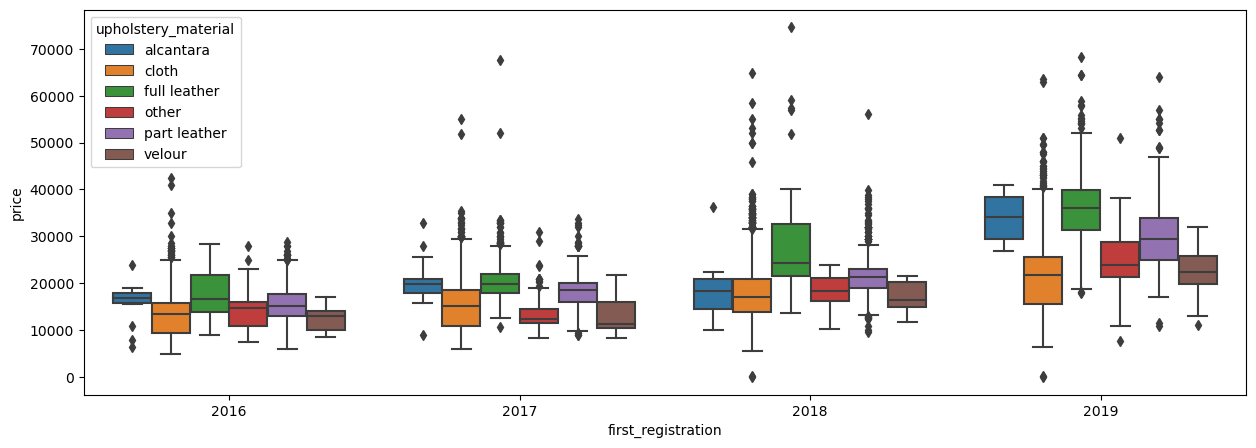

In [154]:
plot_box(df, 'first_registration','price','upholstery_material')

### upholstery_color

In [155]:
df.upholstery_color.value_counts(dropna=False)

black     13204
grey       1360
other      1016
brown       207
beige        54
blue         16
white        13
red           9
yellow        4
orange        1
Name: upholstery_color, dtype: int64

In [156]:
other = set()
vc = df.upholstery_color.value_counts()
for i in vc.index:
    if vc[i] <50:
        other.add(i)
print(other)

{'red', 'orange', 'white', 'blue', 'yellow'}


In [157]:
df['upholstery_color'] = ['other' if x in other else x for x in df.upholstery_color]

In [158]:
df.upholstery_color.value_counts(dropna=False)

black    13204
grey      1360
other     1059
brown      207
beige       54
Name: upholstery_color, dtype: int64

Text(0.1, 0.95, 'brown upholstery seem more expensive')

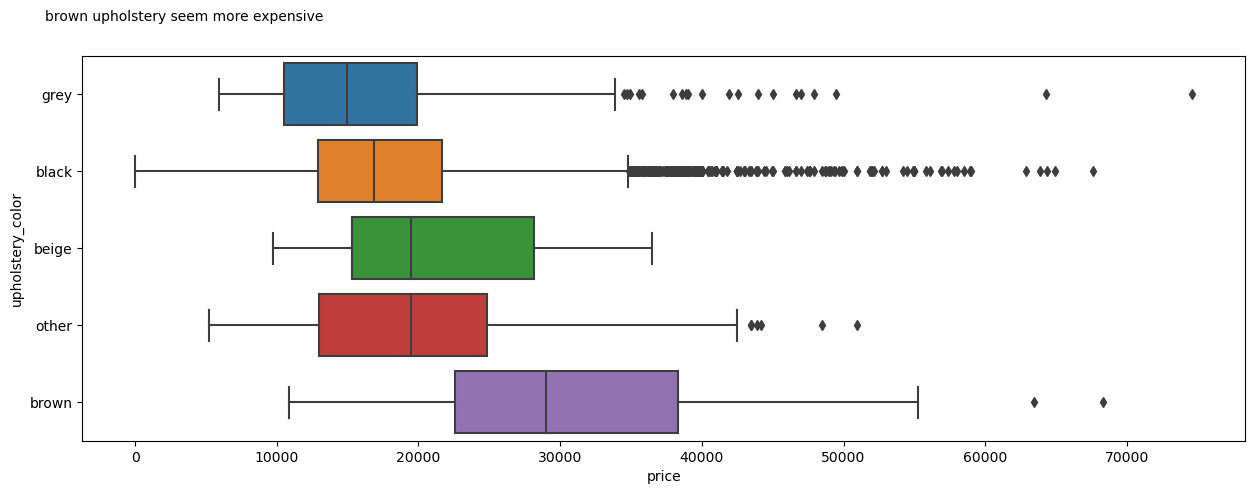

In [159]:
plot_box(df,'upholstery_color','price')
plt.figtext(.1,.95,'brown upholstery seem more expensive')

Text(0.1, 0.95, 'brown upholstery seem more expensive')

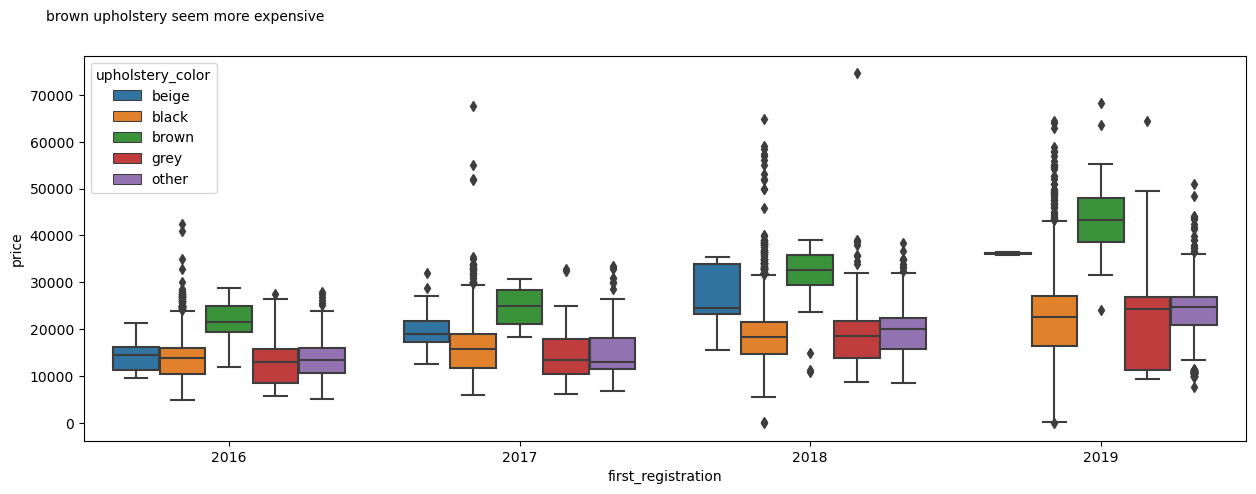

In [160]:
plot_box(df,'first_registration','price','upholstery_color')
plt.figtext(.1,.95,'brown upholstery seem more expensive')

Text(0.1, 0.95, 'brown upholstery are more expensive only for opel_insignia')

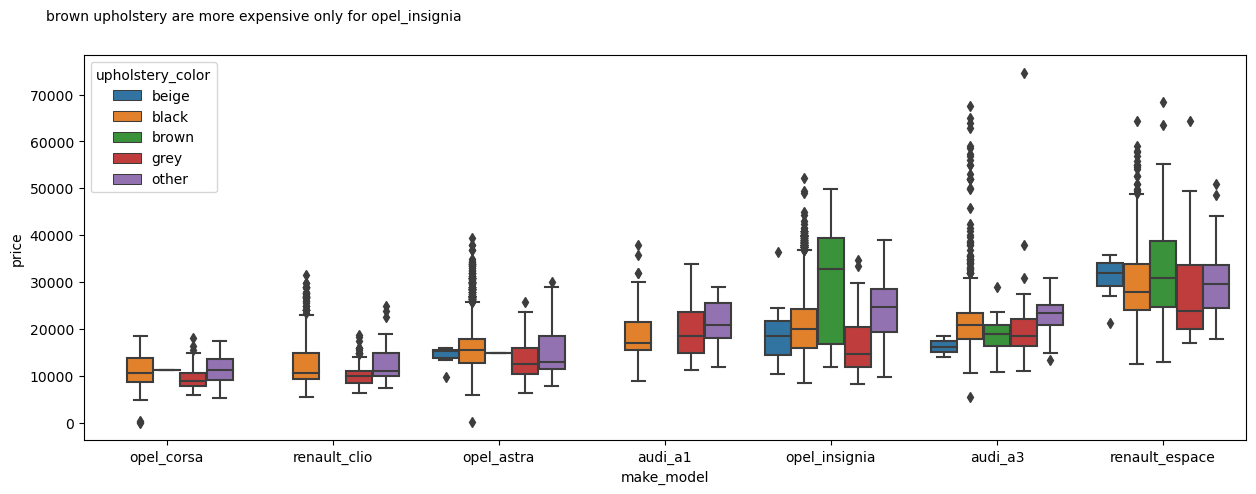

In [161]:
plot_box(df,'make_model','price','upholstery_color')
plt.figtext(.1,.95,'brown upholstery are more expensive only for opel_insignia')

### consumption_*

* outliers seems to be one decimal place away. I impute outlying values by replacing with value/10

#### comb

<AxesSubplot:ylabel='Frequency'>

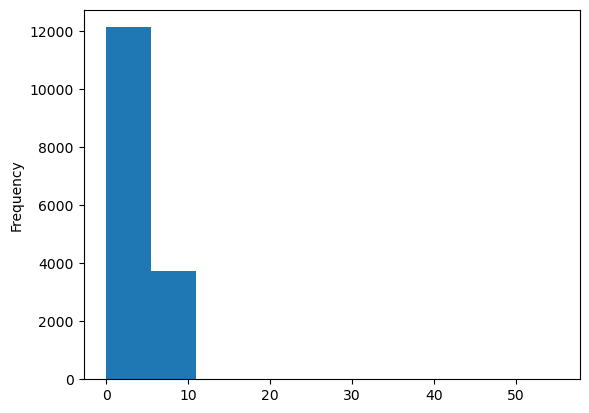

In [162]:
df.consumption_comb.plot.hist()

<AxesSubplot:ylabel='Frequency'>

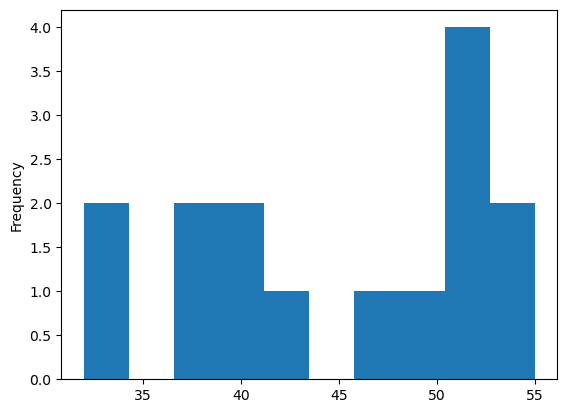

In [163]:
df[df.consumption_comb>14].consumption_comb.plot.hist()

In [164]:
df[df.consumption_comb>14].consumption_comb.value_counts()

51.0    4
40.0    2
38.0    2
43.0    1
55.0    1
54.0    1
32.0    1
33.0    1
50.0    1
46.0    1
Name: consumption_comb, dtype: int64

In [165]:
df[df.consumption_comb>14][['make_model', 'type', 'fuel','consumption_city', 'consumption_country']]

make_model  type    fuel  consumption_city  consumption_country
500           audi_a1  used     gas          5.100000             3.800000
2194          audi_a1   new     gas         62.000000            44.000000
2196          audi_a1   new     gas         62.000000            44.000000
2210          audi_a1   new     gas         62.000000            44.000000
2237          audi_a1   new     gas         62.000000            44.000000
4088          audi_a3  used  diesel         45.000000            37.000000
4101          audi_a3  used  diesel         45.000000            37.000000
4555          audi_a3  used  diesel         43.000000            35.000000
4557          audi_a3  used  diesel         43.000000            35.000000
11953   opel_insignia  used  diesel          7.300000             4.500000
13178    renault_clio  used     gas          6.998148             4.631481
14130    renault_clio  used  diesel          3.615254             3.150847
14529    renault_clio  used  diesel          4.081818             3.390909
14583    renault_clio   new     gas         64.000000            42.000000
15032  renault_espace  used  diesel          5.067742             4.361290

In [166]:
df.loc[df.consumption_comb>14,'consumption_comb'] =df[df.consumption_comb>14].consumption_comb/10

#### city

<AxesSubplot:ylabel='Frequency'>

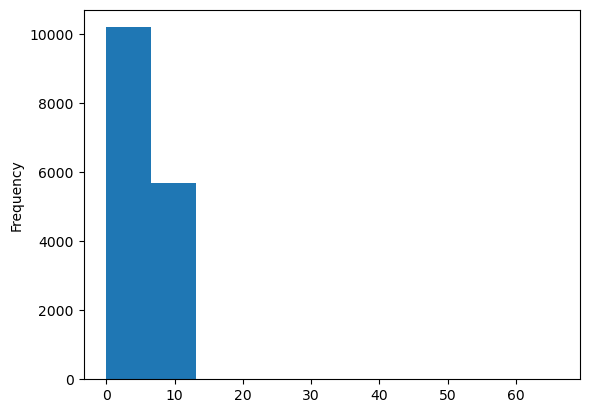

In [167]:
df.consumption_city.plot.hist()

<AxesSubplot:ylabel='Frequency'>

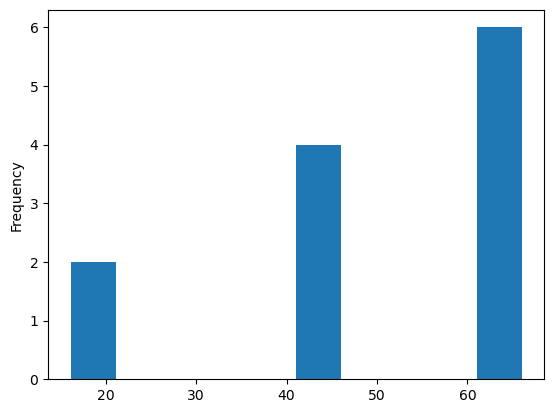

In [168]:
df[df.consumption_city>11.5].consumption_city.plot.hist()

In [169]:
df.loc[df.consumption_city>11.5,'consumption_city'] =df[df.consumption_city>11.5].consumption_city/10

<AxesSubplot:ylabel='Frequency'>

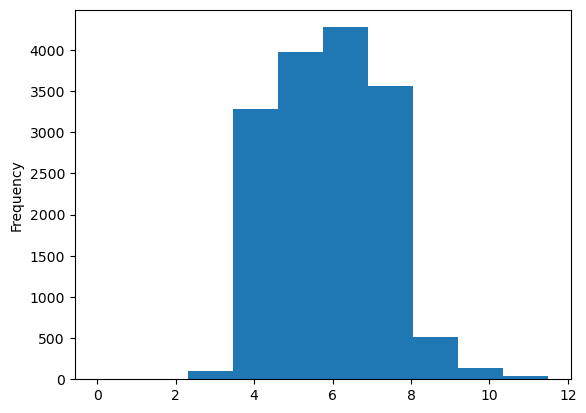

In [170]:
df.consumption_city.plot.hist()

#### country

<AxesSubplot:ylabel='Frequency'>

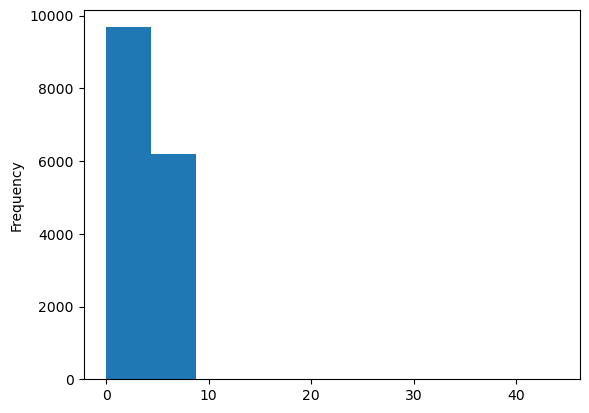

In [171]:
df.consumption_country.plot.hist()

<AxesSubplot:ylabel='Frequency'>

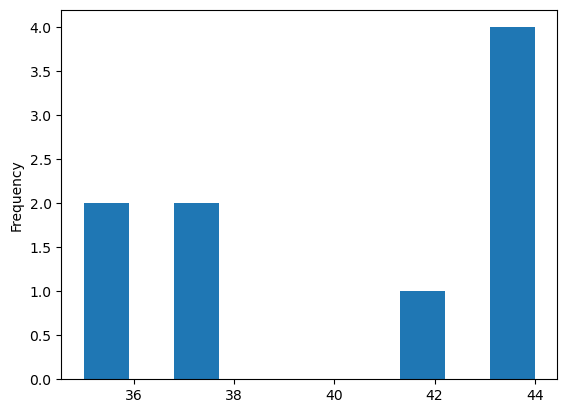

In [172]:
df[df.consumption_country>15].consumption_country.plot.hist()

In [173]:
df.loc[df.consumption_country>15,'consumption_country'] =df[df.consumption_country>15].consumption_country/10

<AxesSubplot:ylabel='Frequency'>

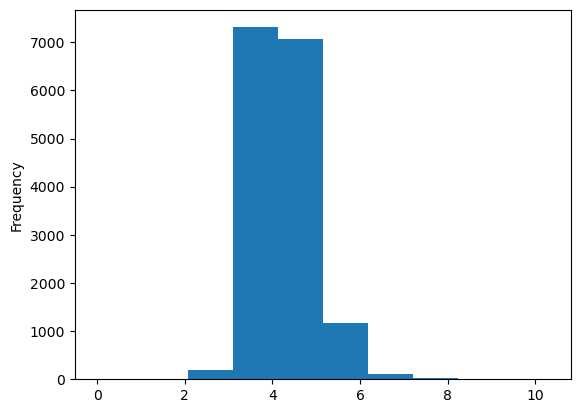

In [174]:
df.consumption_country.plot.hist()

In [175]:
df[['consumption_comb','price']].corr()

consumption_comb     price
consumption_comb          1.000000  0.306706
price                     0.306706  1.000000

In [176]:
df[['consumption_city','price']].corr()

consumption_city     price
consumption_city          1.000000  0.232436
price                     0.232436  1.000000

In [177]:
df[['consumption_country','price']].corr()

consumption_country     price
consumption_country             1.000000  0.374133
price                           0.374133  1.000000

### reg_cont
* we can drop this variable

In [178]:
df[['reg_cont','price']].corr()

reg_cont    price
reg_cont   1.00000  0.47349
price      0.47349  1.00000

In [179]:
df[['reg_cont','first_registration']].corr()

reg_cont  first_registration
reg_cont            1.000000            0.974909
first_registration  0.974909            1.000000

In [180]:
df = df.drop('reg_cont',axis=1)

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15884 entries, 0 to 15883
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   make_model           15884 non-null  object 
 1   body_type            15884 non-null  object 
 2   price                15884 non-null  int64  
 3   km                   15884 non-null  float64
 4   prev_owner           15884 non-null  int64  
 5   hp                   15884 non-null  int64  
 6   type                 15884 non-null  object 
 7   first_registration   15884 non-null  int64  
 8   body_color           15884 non-null  object 
 9   paint_type           15884 non-null  object 
 10  nr_doors             15884 non-null  object 
 11  nr_seats             15884 non-null  object 
 12  gearing_type         15884 non-null  object 
 13  displacement         15884 non-null  float64
 14  cylinders            15884 non-null  object 
 15  weight               15884 non-null 

### save the current version of data

In [185]:
df = df.drop(['gears_str', 'vat'], axis=1)

In [186]:
df.to_json('data_post02.json', orient='records', lines=True)

### Summary

* in this part I observed all features once again by visualizing them to see outlying values. 
* I group them by some other features and visualize to see outliers, 
* I also observed how the prices vary with the feature and by the groups using other features
* I imputed entries that are implausible with plausible entries.
* I dropped reg_cont.

<a id="3"></a>

## End of Handing Outliers

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

## Next: [Modeling](04_modeling.ipynb)